In [1]:
%run setup.ipynb
%aimport peakfit

In [2]:
xpehh_raw = phase1_selection.xpehh_raw
xpehh_raw

Group(/, 5)
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [3]:
comparisons = list(xpehh_raw['X'])
comparisons

['AOMvsGWA',
 'BFMvsAOM',
 'BFMvsGWA',
 'BFSvsBFM',
 'BFSvsGWA',
 'BFSvsUGS',
 'CMS_savannavsBFS',
 'CMS_savannavsGAS',
 'CMS_savannavsGWA',
 'CMS_savannavsUGS',
 'GASvsAOM',
 'GASvsBFS',
 'GASvsGWA',
 'UGSvsGWA']

In [4]:
seqids

('2R', '2L', '3R', '3L', 'X')

In [5]:
sorted(genome)

['2L', '2R', '3L', '3R', 'UNKN', 'X', 'Y_unplaced']

In [6]:
def build_dataframe(focal_pop, ref_pop, flipped=False, seqid=None, window_size=800):
    
    if seqid is None:
        df = pd.concat([build_dataframe(focal_pop, ref_pop, flipped=flipped, seqid=seqid) for seqid in seqids])
        return df
        
    # extract raw values
    pop1, pop2 = focal_pop, ref_pop
    if flipped:
        pop1, pop2 = pop2, pop1
    comparison = '%svs%s' % (pop1, pop2)
    grp = xpehh_raw[seqid][comparison]
    pos = grp['POS'][:]
    values = grp['XPEHH_zscore'][:]
    if flipped:
        values = -values
    nomiss = ~np.isnan(values) & (values > 0)
    pos_nomiss = pos[nomiss]
    values_nomiss = values[nomiss]
    
    # construct moving windows
    starts_col = allel.moving_statistic(pos_nomiss, statistic=lambda v: v[0], size=window_size)
    starts_col[0] = 1  # fix to start of sequence
    ends_col = np.append(starts_col[1:] - 1, [len(genome[seqid])])
    
    # summarise values in windows
    values_col = allel.moving_statistic(values_nomiss, statistic=np.max, size=window_size)
    
    # seqid column
    seqid_col = np.array([seqid] * len(starts_col))
    
    # build dataframe
    df = pd.DataFrame.from_items([
        ('seqid', seqid_col), 
        ('start', starts_col), 
        ('end', ends_col), 
        ('value', values_col)
    ])
    return df

    
    

## Check peak fitters

In [7]:
df = build_dataframe('BFS', 'GWA')
df.head()

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


seqid  start     end     value
0    2R      1   31433  1.668300
1    2R  31434   49729  2.674605
2    2R  49730   73462  1.483737
3    2R  73463   93497  2.058329
4    2R  93498  111305  2.049382

In [8]:
df.tail()

seqid     start       end     value
1034     X  19389971  19410088  1.454079
1035     X  19410089  19650094  1.169734
1036     X  19650095  19841714  1.142727
1037     X  19841715  23372431  1.400026
1038     X  23372432  24393108  2.094701

In [9]:
starts, ends, values, percentiles = peakfit.extract_windowed_values(df, seqid=('2R', '2L'), genome=genome)

In [10]:
starts

array([        1,     31434,     49730, ..., 110775286, 110790100,
       110817412], dtype=int32)

In [11]:
ends

array([    31433,     49729,     73462, ..., 110790099, 110817411,
       110909430])

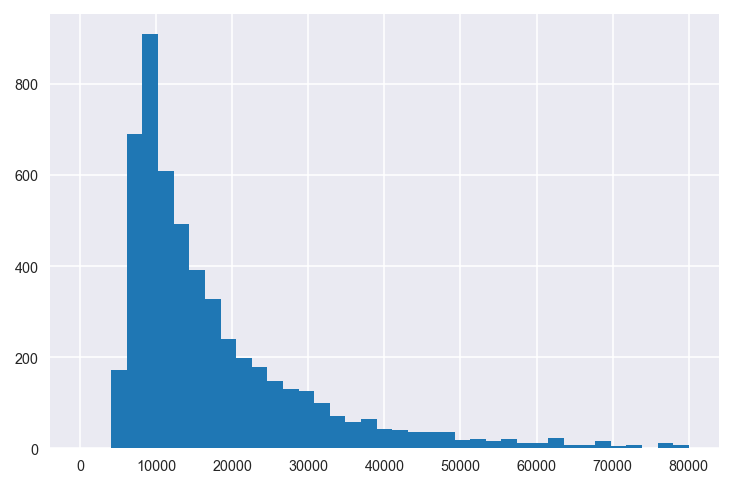

In [12]:
plt.hist(ends-starts, bins=np.linspace(0, 80000, 40));

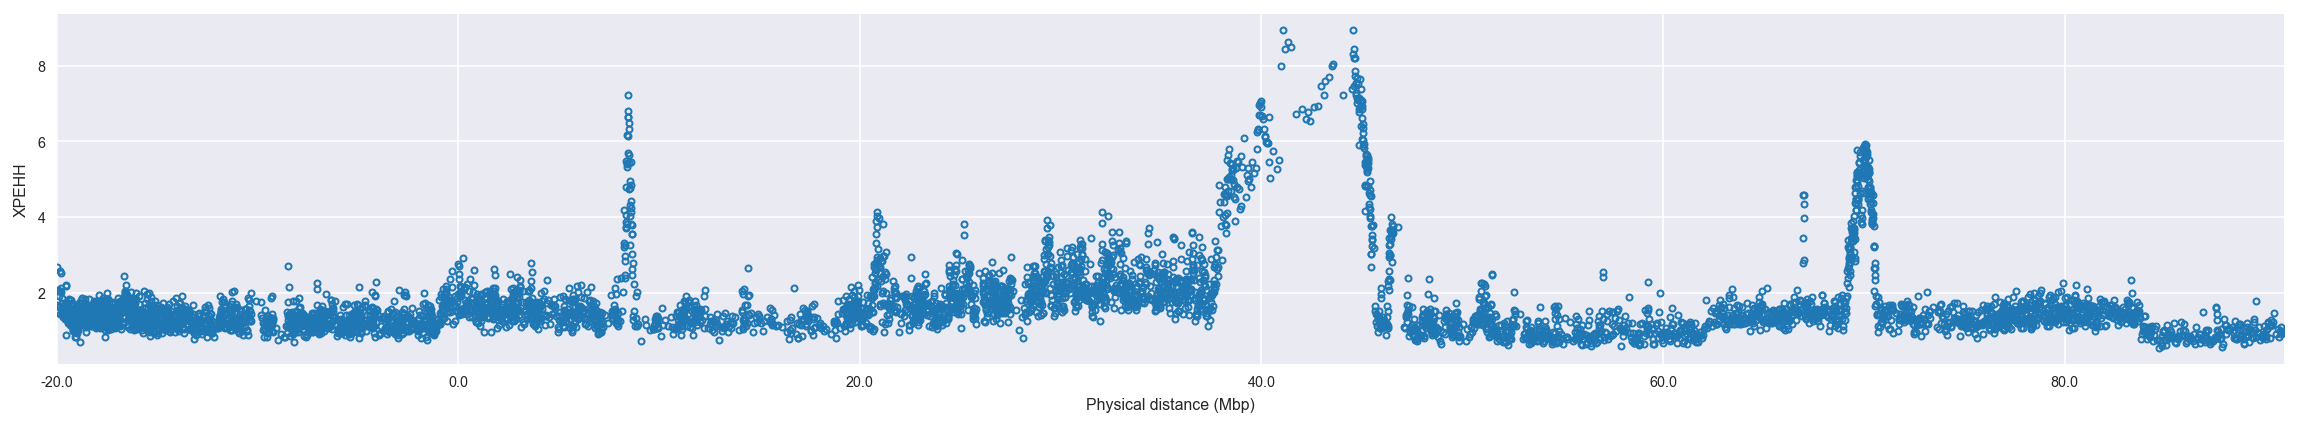

In [13]:
peakfit.plot_windowed_values(starts, ends, values, ylabel='XPEHH');

peakfit.plot_windowed_values(starts, ends, values, ylabel='XPEHH', gmap=gmap['2']);

In [28]:
symexp_fitter = peakfit.ExponentialPeakFitter(
    amplitude=lmfit.Parameter(value=3, vary=True, min=0),
    decay=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    baseline=lmfit.Parameter(value=1, vary=True, min=0, max=5),
    ceiling=lmfit.Parameter(value=5, vary=True, min=0),
    floor=lmfit.Parameter(value=0, vary=False),
    null=lmfit.Parameter(value=1, vary=True, min=0)
)


asymexp_fitter = peakfit.AsymmetricDecayExponentialPeakFitter(
    amplitude=lmfit.Parameter(value=3, vary=True, min=0),
    decay_left=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    decay_right=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    baseline=lmfit.Parameter(value=1, vary=True, min=0, max=5),
    ceiling=lmfit.Parameter(value=5, vary=True, min=0),
    floor=lmfit.Parameter(value=0, vary=False),
    null=lmfit.Parameter(value=1, vary=True, min=0)
)


gauss_fitter = peakfit.GaussianPeakFitter(
    amplitude=lmfit.Parameter(value=3, vary=True, min=0),
    sigma=lmfit.Parameter(value=0.2, vary=True, min=0.05, max=3),
    baseline=lmfit.Parameter(value=1, vary=True, min=0, max=5),
    null=lmfit.Parameter(value=1, vary=True, min=0)
)


def inspect_peak_fits(center, flank):

    x = ((starts + ends) / 2).astype(int)
    x = gmap['2'].take(x - 1)
    y = values

    fit = symexp_fitter.fit(x, y, center, flank)
    fig = peakfit.plot_peak_fit(fit, dpi=150, ylabel='max XPEHH')
    fig.suptitle('Exponential peak', fontsize=12, fontweight='bold', y=1.03)
    plt.show()
    print(fit.peak_result.fit_report())

    fit = asymexp_fitter.fit(x, y, center, flank)
    fig = peakfit.plot_peak_fit(fit, dpi=150, ylabel='max XPEHH')
    fig.suptitle('Exponential peak with asymmetric decay', fontsize=12, fontweight='bold', y=1.03)
    plt.show()
    print(fit.peak_result.fit_report())
    
    fit = gauss_fitter.fit(x, y, center, flank)
    fig = peakfit.plot_peak_fit(fit, dpi=150, ylabel='max XPEHH')
    fig.suptitle('Gaussian', fontsize=12, fontweight='bold', y=1.03)
    plt.show()
    print(fit.peak_result.fit_report())
    
    

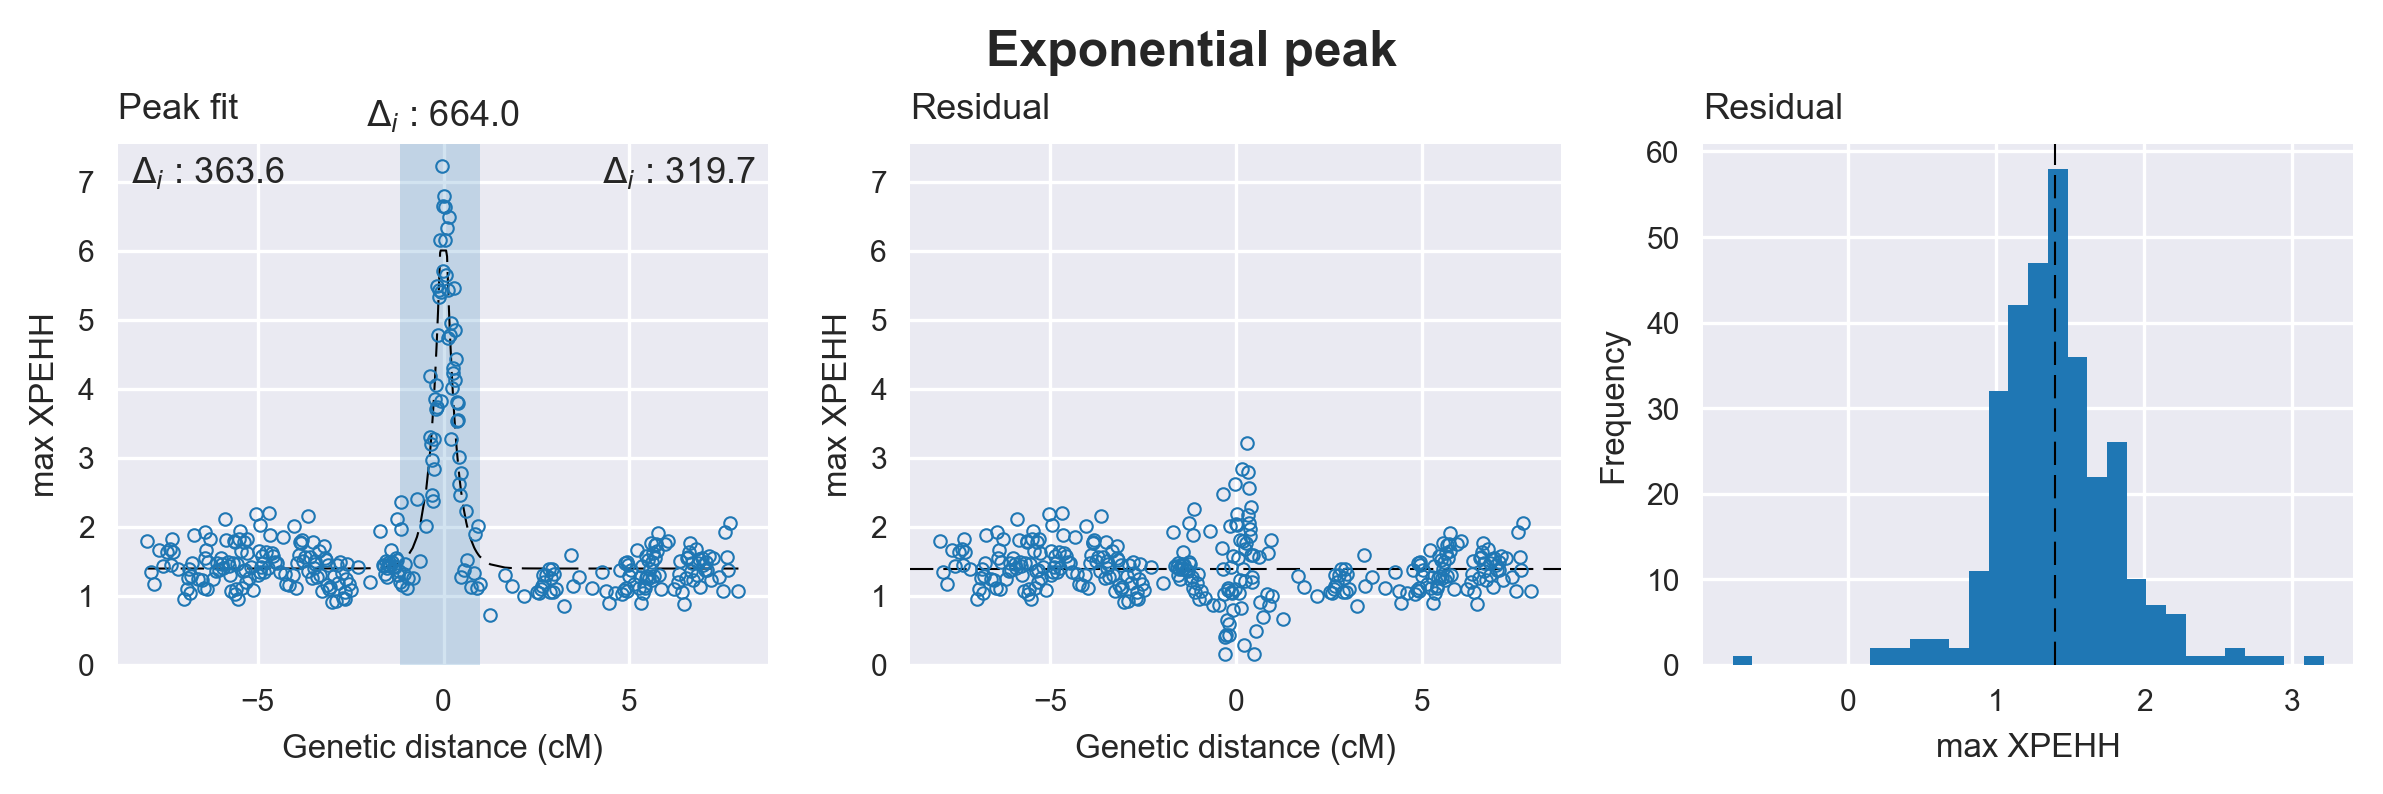

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 317
    # variables        = 4
    chi-square         = 54.947
    reduced chi-square = 0.176
    Akaike info crit   = -547.554
    Bayesian info crit = -532.519
[[Variables]]
    center:      0 (fixed)
    amplitude:   6.43217512 +/- 0.336295 (5.23%) (init= 3)
    decay:       0.27042583 +/- 0.017632 (6.52%) (init= 0.2)
    baseline:    1.39476468 +/- 0.026482 (1.90%) (init= 1)
    ceiling:     6.00153155 +/- 0.139661 (2.33%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay)          = -0.873 
    C(decay, baseline)           = -0.257 



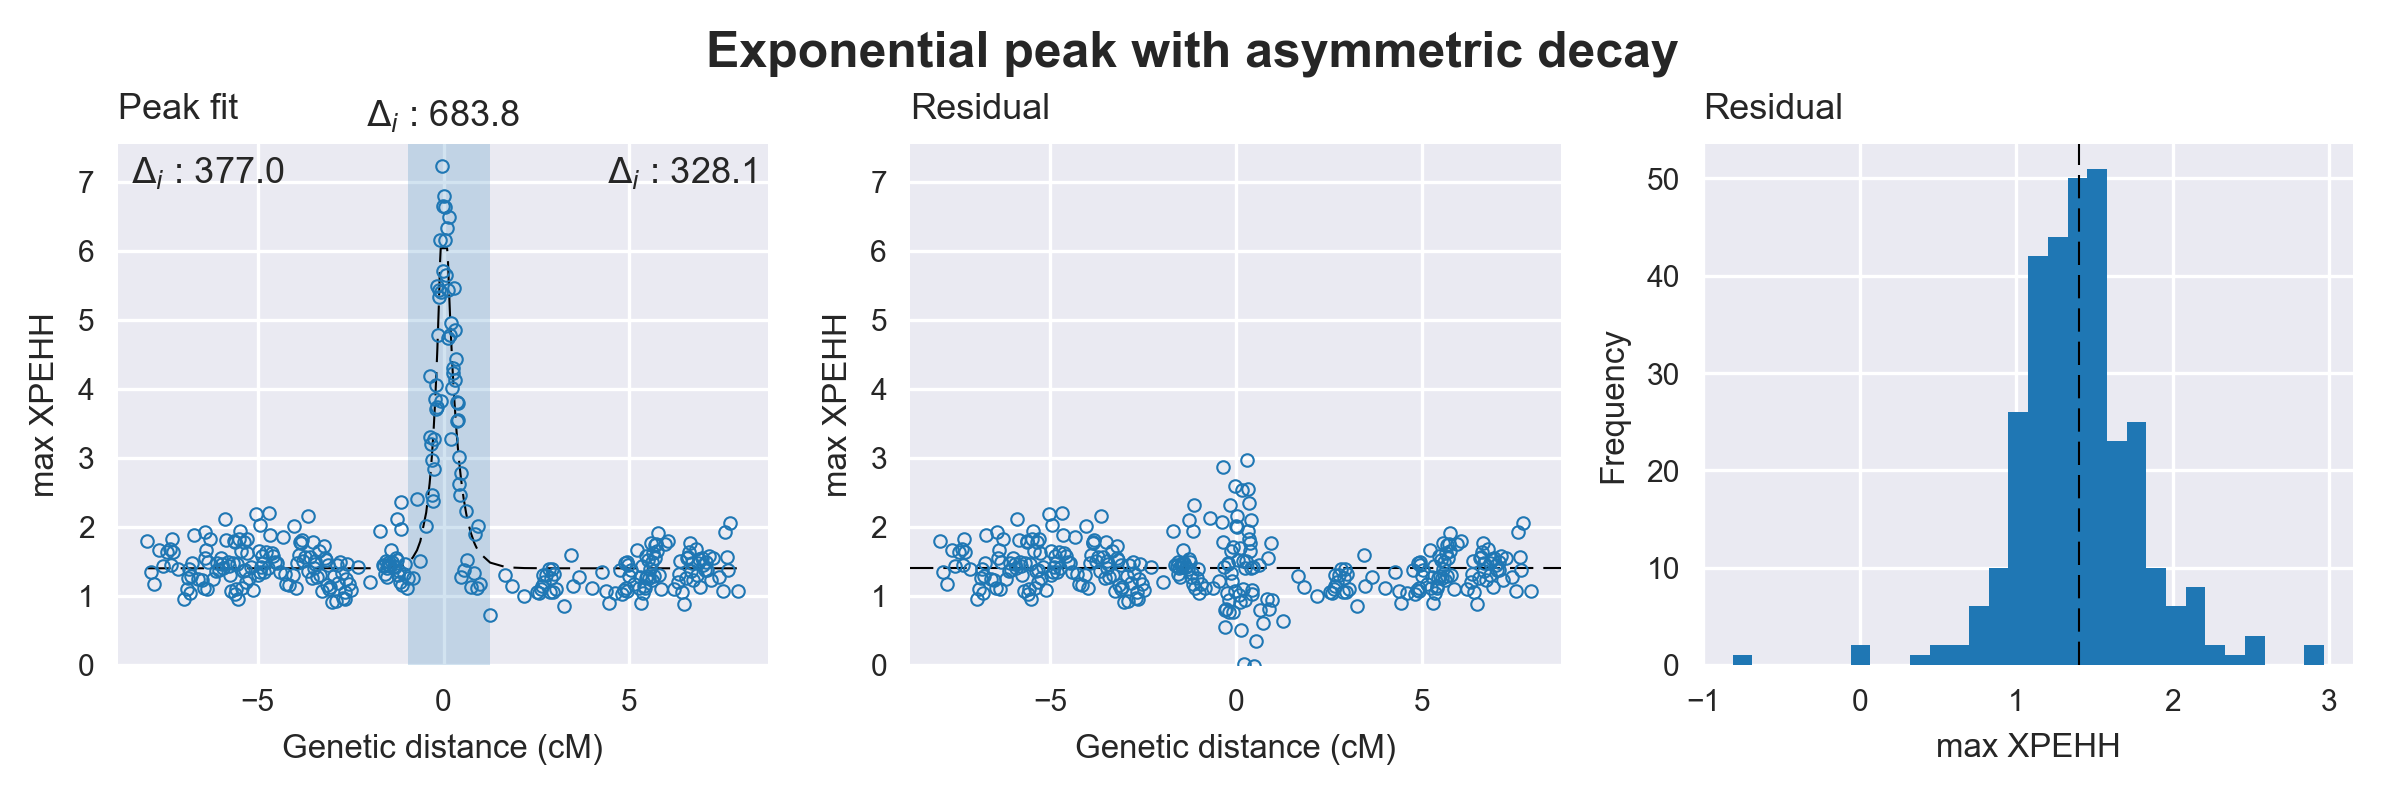

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 51
    # data points      = 317
    # variables        = 5
    chi-square         = 51.298
    reduced chi-square = 0.164
    Akaike info crit   = -567.334
    Bayesian info crit = -548.540
[[Variables]]
    center:        0 (fixed)
    amplitude:     6.77520852 +/- 0.382881 (5.65%) (init= 3)
    decay_left:    0.21934435 +/- 0.016063 (7.32%) (init= 0.2)
    decay_right:   0.28470919 +/- 0.019317 (6.78%) (init= 0.2)
    baseline:      1.39836671 +/- 0.025433 (1.82%) (init= 1)
    ceiling:       6.03460202 +/- 0.128225 (2.12%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay_right)    = -0.838 
    C(amplitude, decay_left)     = -0.809 
    C(decay_left, decay_right)   =  0.708 
    C(decay_right, baseline)     = -0.218 
    C(decay_left, baseline)      = -0.209 



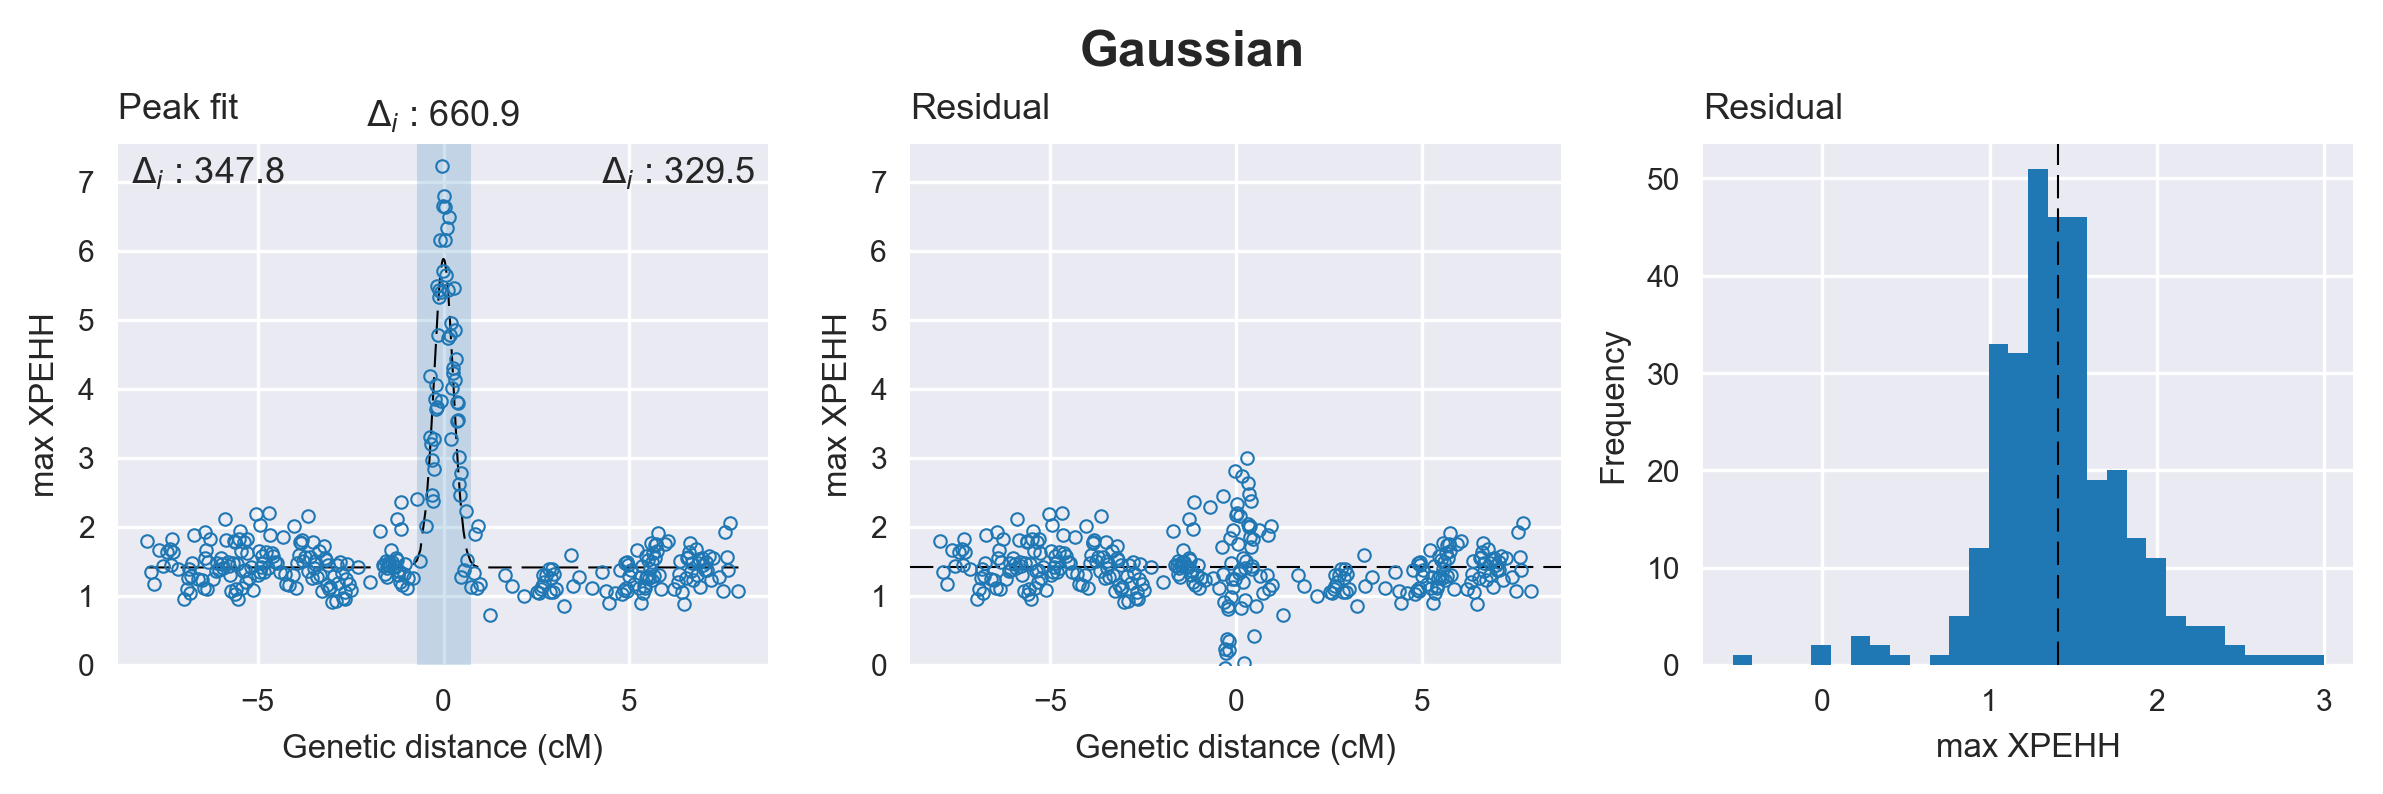

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 317
    # variables        = 3
    chi-square         = 55.832
    reduced chi-square = 0.178
    Akaike info crit   = -544.487
    Bayesian info crit = -533.211
[[Variables]]
    center:      0 (fixed)
    amplitude:   2.91661033 +/- 0.081337 (2.79%) (init= 3)
    sigma:       0.26034907 +/- 0.008460 (3.25%) (init= 0.2)
    c:           1.41074917 +/- 0.025974 (1.84%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.681 
    C(amplitude, c)              = -0.394 
    C(sigma, c)                  = -0.185 



In [33]:
inspect_peak_fits(center=56.9, flank=8)

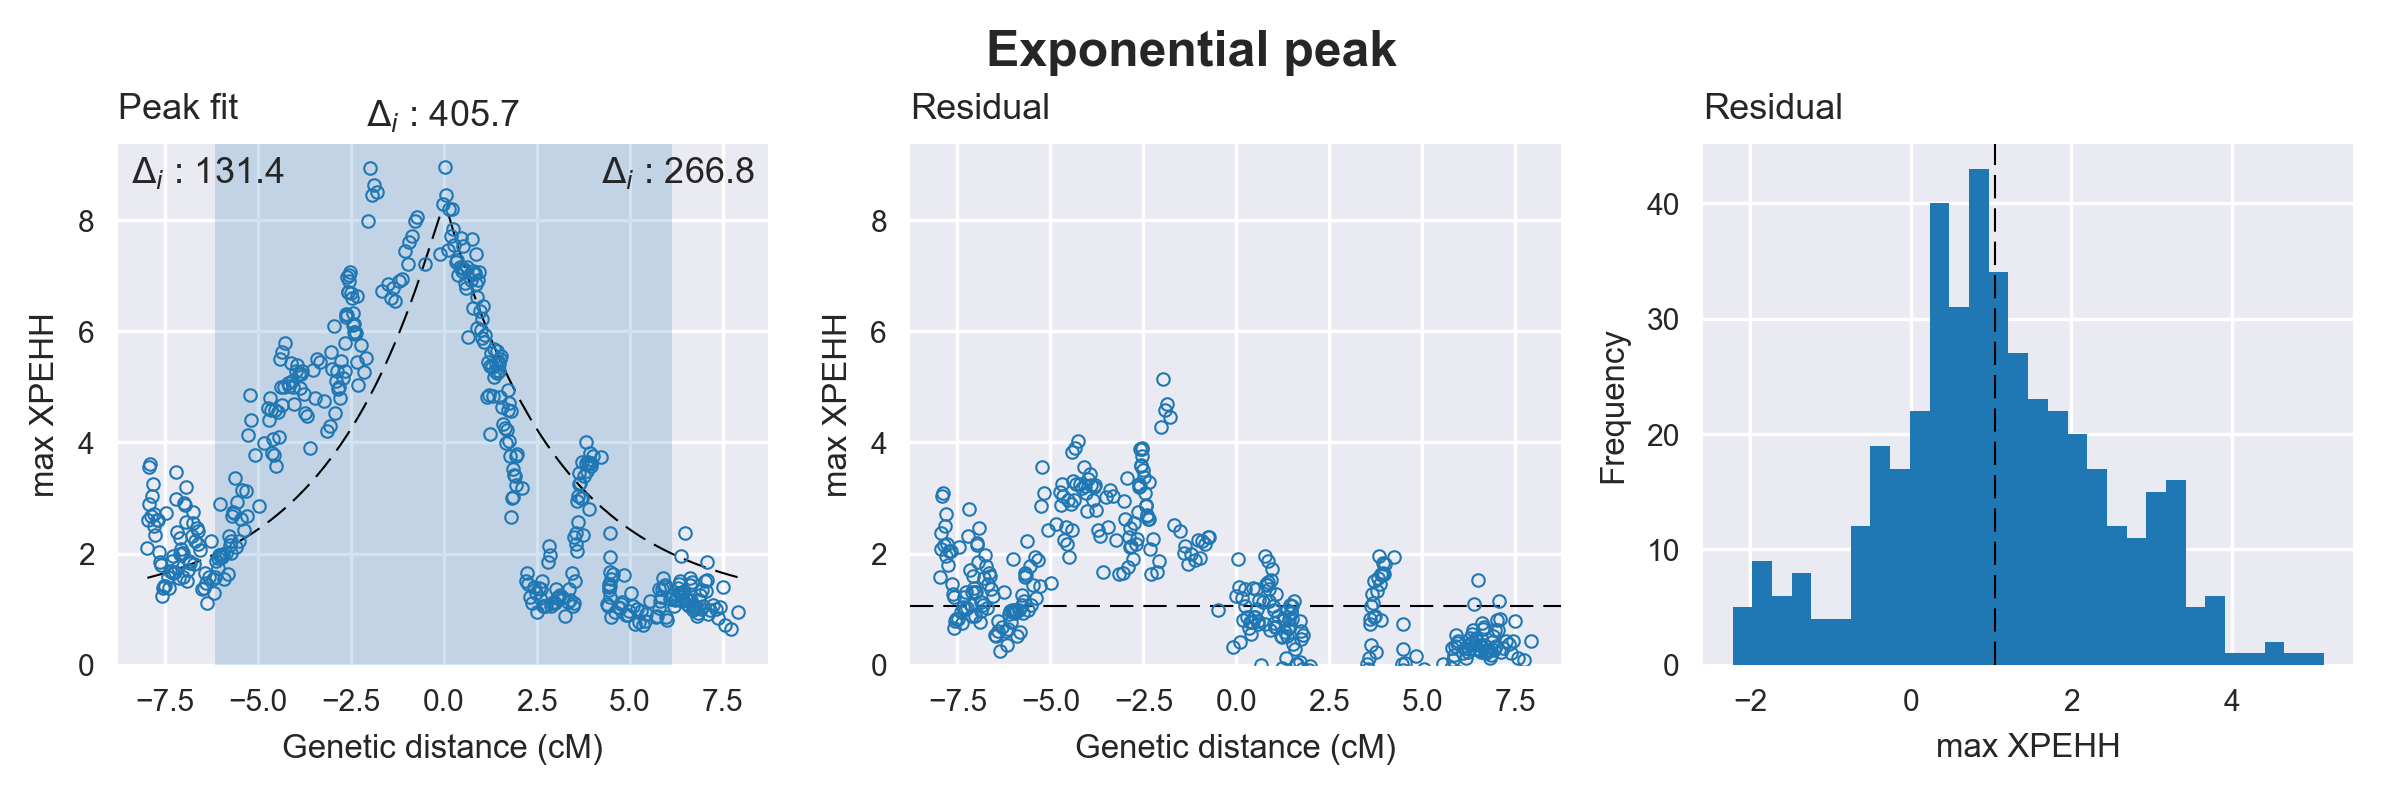

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 434
    # variables        = 4
    chi-square         = 820.444
    reduced chi-square = 1.908
    Akaike info crit   = 284.372
    Bayesian info crit = 300.664
[[Variables]]
    center:      0 (fixed)
    amplitude:   7.34656917 +/- 0.290897 (3.96%) (init= 3)
    decay:       2.99289888 +/- 0.403233 (13.47%) (init= 0.2)
    baseline:    1.05167906 +/- 0.312924 (29.75%) (init= 1)
    ceiling:     8.10889999 +/- 0.617739 (7.62%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay, baseline)           = -0.930 
    C(amplitude, baseline)       = -0.361 



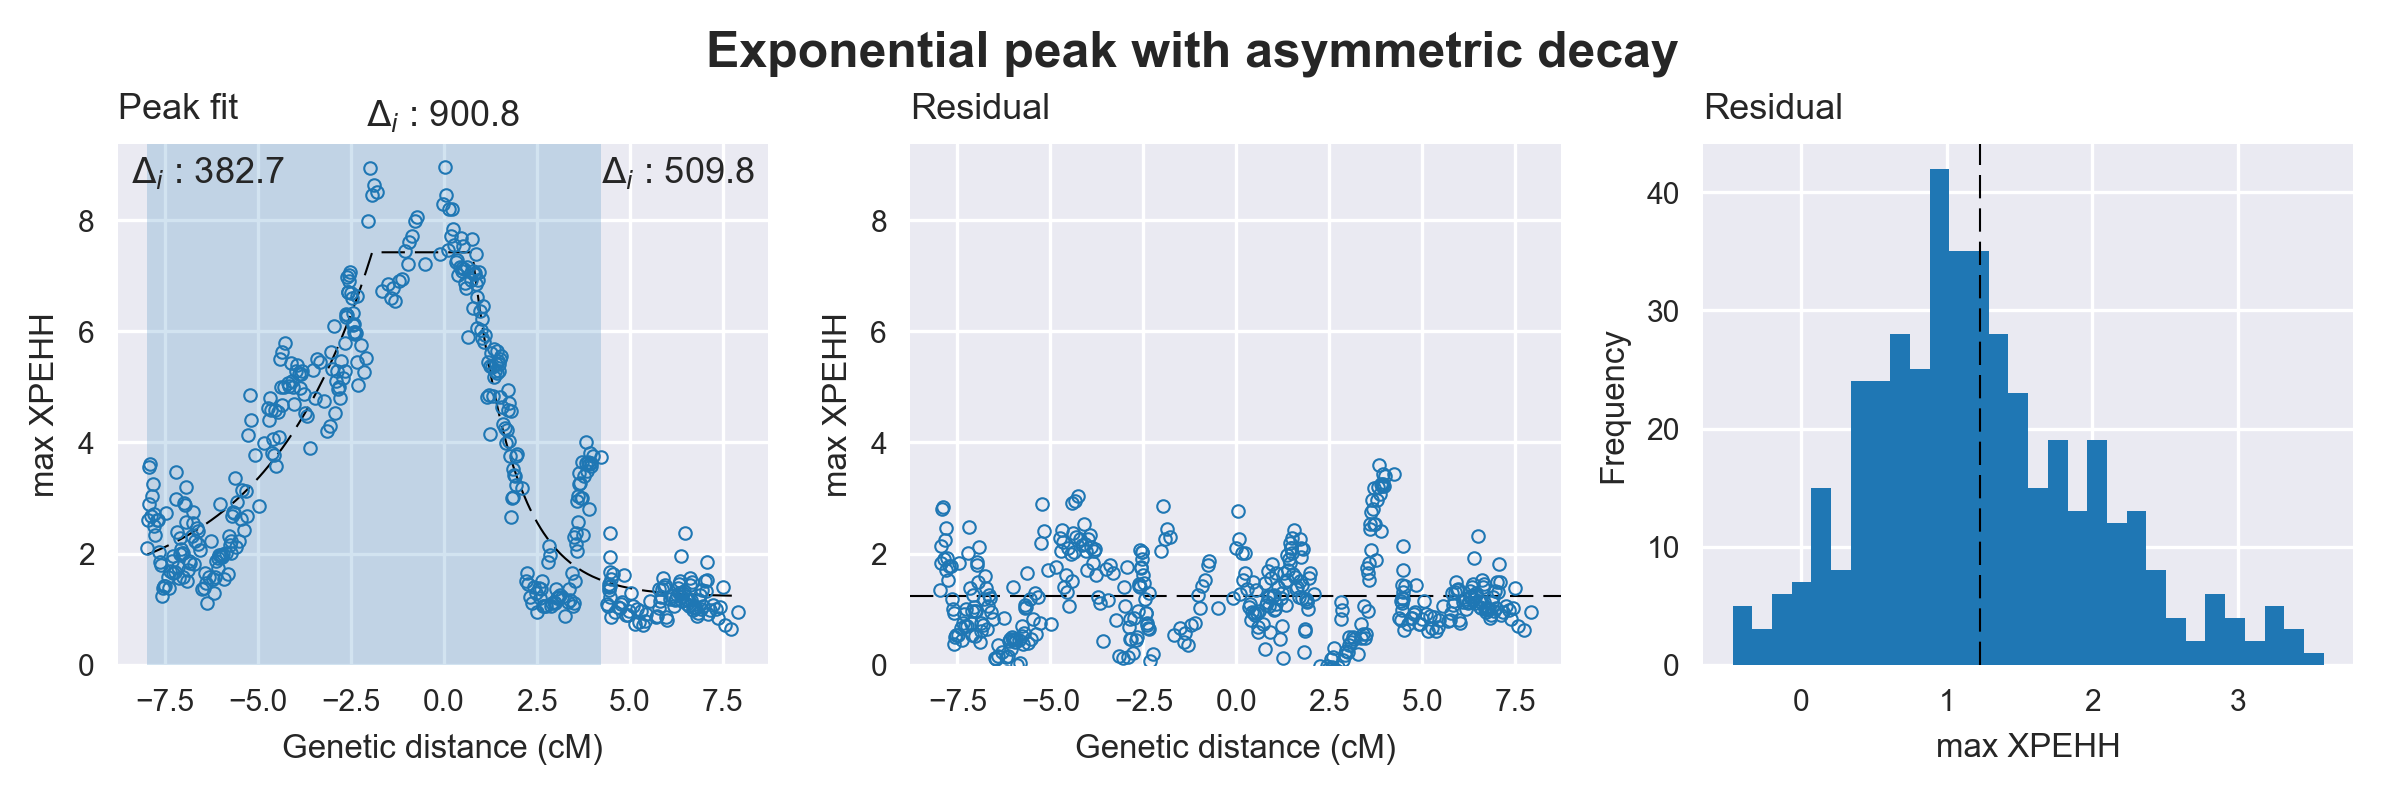

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 58
    # data points      = 434
    # variables        = 5
    chi-square         = 261.029
    reduced chi-square = 0.608
    Akaike info crit   = -210.651
    Bayesian info crit = -190.286
[[Variables]]
    center:        0 (fixed)
    amplitude:     12.1077325 +/- 0.572820 (4.73%) (init= 3)
    decay_left:    2.87045596 +/- 0.156574 (5.45%) (init= 0.2)
    decay_right:   1.13554733 +/- 0.066302 (5.84%) (init= 0.2)
    baseline:      1.23043681 +/- 0.087601 (7.12%) (init= 1)
    ceiling:       7.41813671 +/- 0.121821 (1.64%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(decay_left, decay_right)   =  0.887 
    C(amplitude, decay_left)     = -0.866 
    C(amplitude, decay_right)    = -0.834 
    C(decay_left, baseline)      = -0.736 
    C(decay_right, baseline)     = -0.736 
    C(amplitude, baseline)       =  0.437 



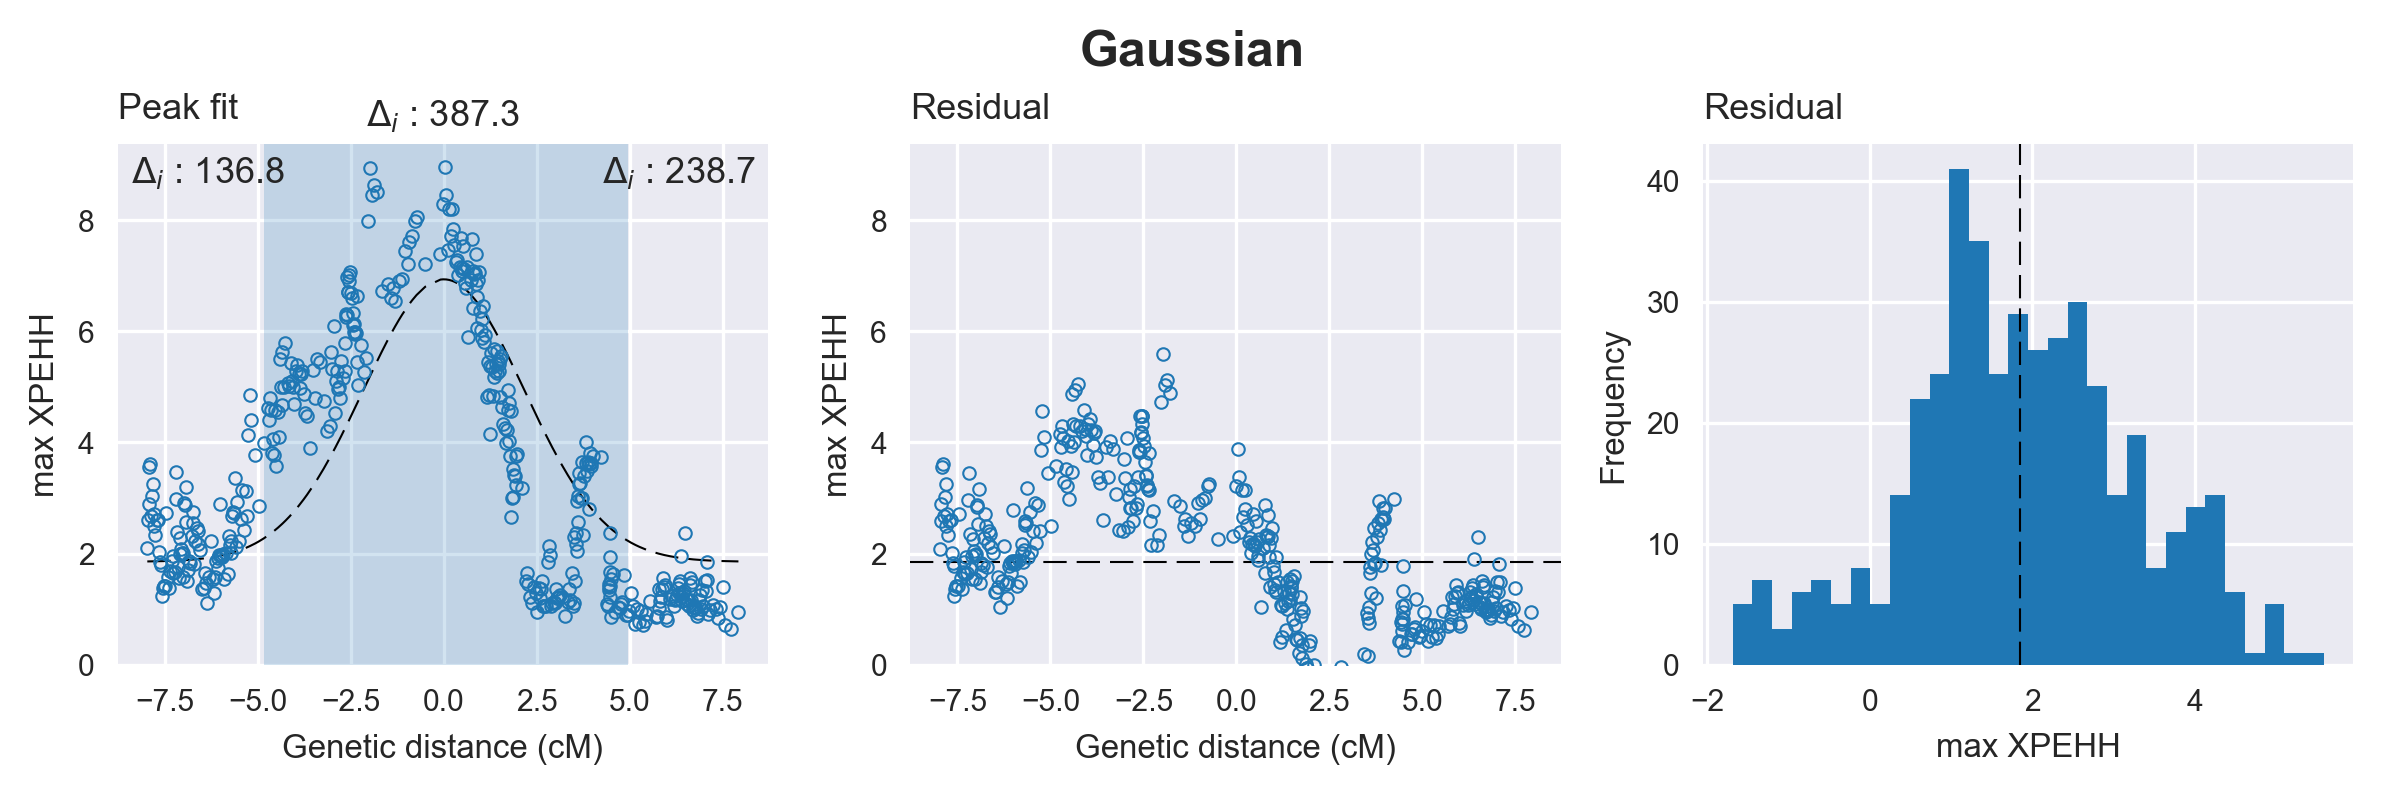

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 434
    # variables        = 3
    chi-square         = 859.917
    reduced chi-square = 1.995
    Akaike info crit   = 302.766
    Bayesian info crit = 314.985
[[Variables]]
    center:      0 (fixed)
    amplitude:   27.6021184 +/- 1.671525 (6.06%) (init= 3)
    sigma:       2.16826614 +/- 0.113816 (5.25%) (init= 0.2)
    c:           1.85329738 +/- 0.123537 (6.67%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, c)              = -0.835 
    C(amplitude, sigma)          =  0.761 
    C(sigma, c)                  = -0.659 



In [30]:
inspect_peak_fits(center=121, flank=8)

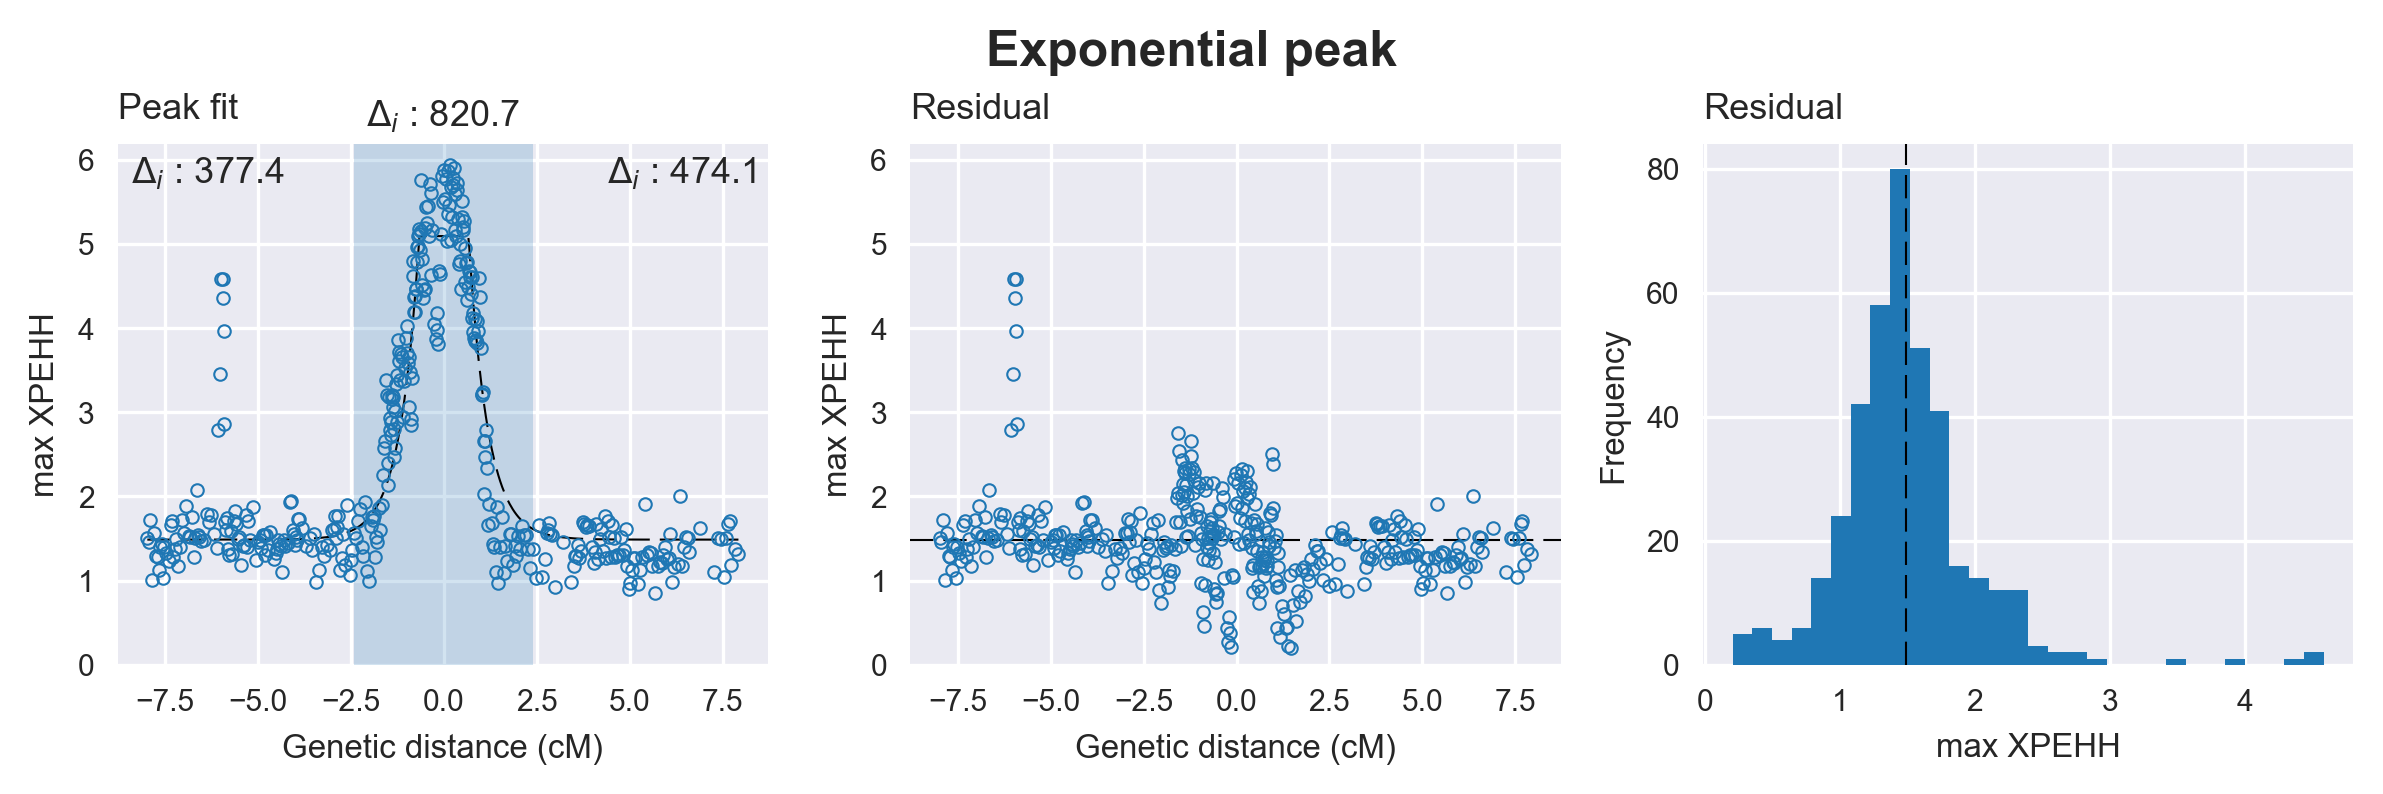

[[Model]]
    Model(exponential_peak)
[[Fit Statistics]]
    # function evals   = 68
    # data points      = 398
    # variables        = 4
    chi-square         = 109.846
    reduced chi-square = 0.279
    Akaike info crit   = -504.374
    Bayesian info crit = -488.428
[[Variables]]
    center:      0 (fixed)
    amplitude:   12.9923711 +/- 1.567335 (12.06%) (init= 3)
    decay:       0.51686063 +/- 0.037717 (7.30%) (init= 0.2)
    baseline:    1.48684803 +/- 0.037048 (2.49%) (init= 1)
    ceiling:     5.09087583 +/- 0.066523 (1.31%) (init= 5)
    floor:       0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay)          = -0.965 
    C(decay, baseline)           = -0.434 
    C(amplitude, baseline)       =  0.300 



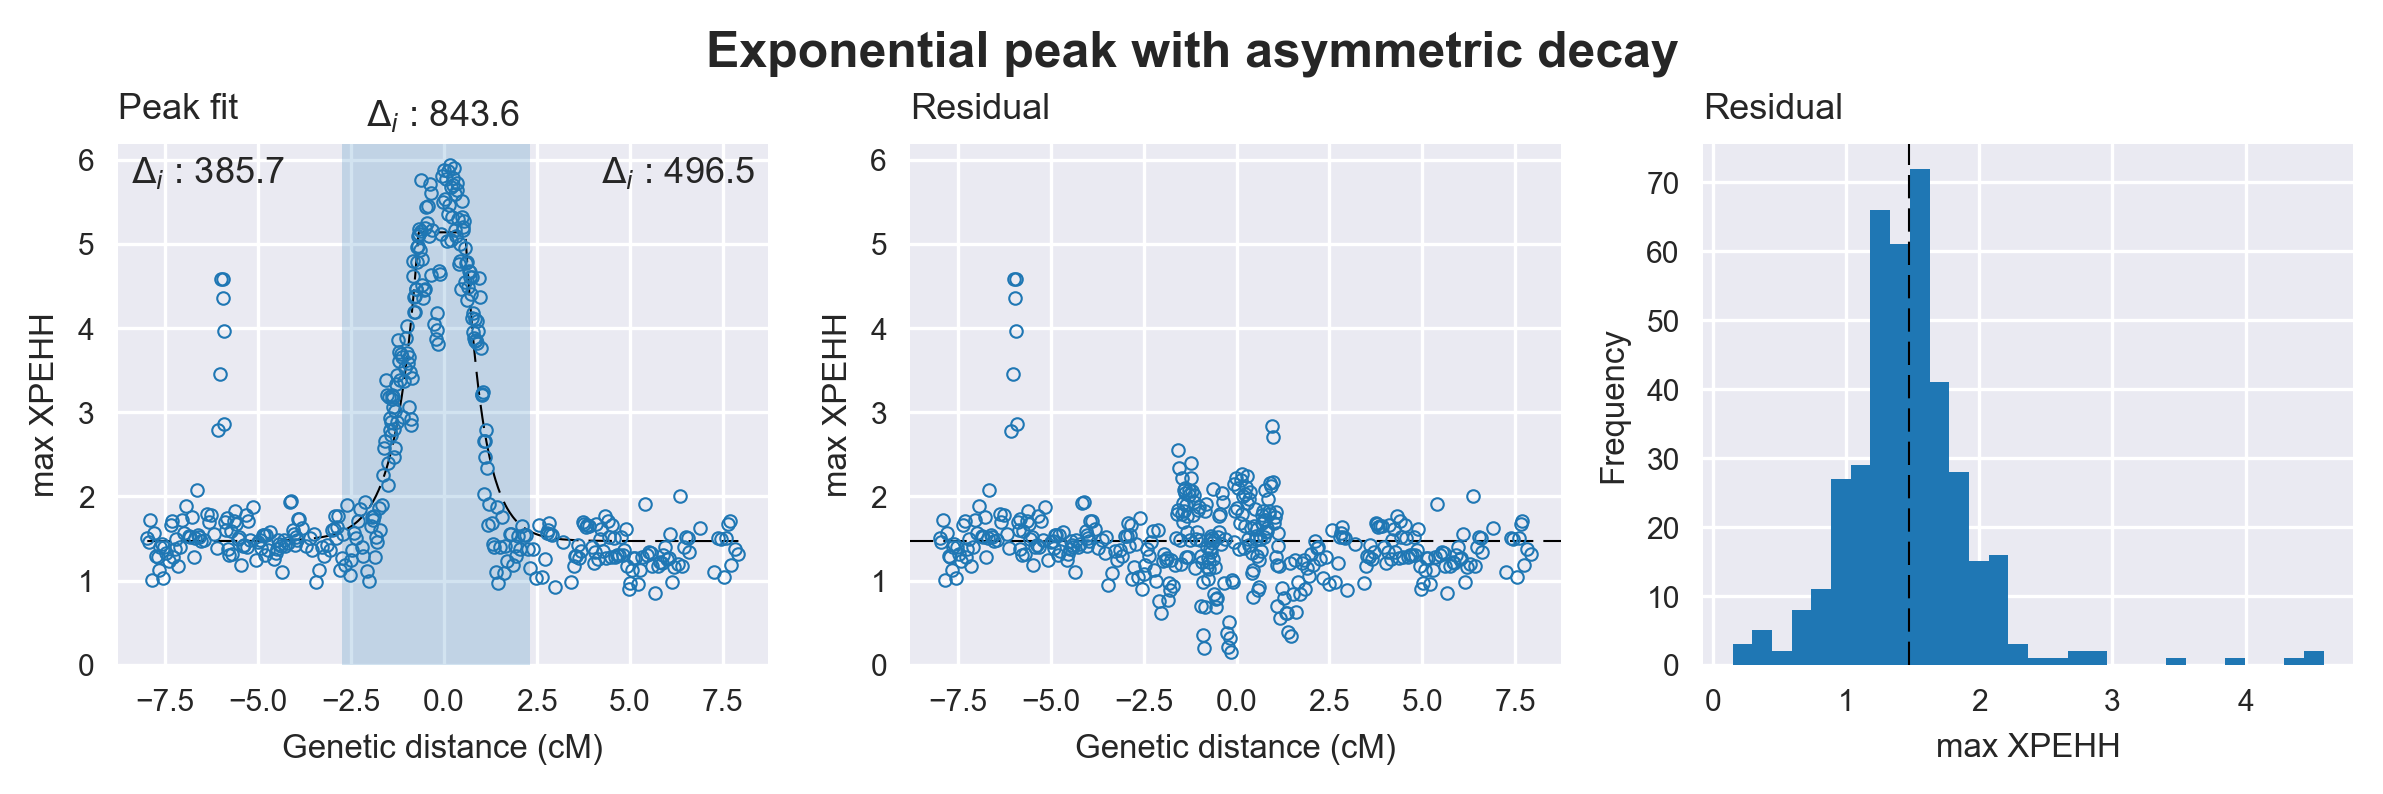

[[Model]]
    Model(asymmetric_decay_exponential_peak)
[[Fit Statistics]]
    # function evals   = 78
    # data points      = 398
    # variables        = 5
    chi-square         = 103.192
    reduced chi-square = 0.263
    Akaike info crit   = -527.245
    Bayesian info crit = -507.313
[[Variables]]
    center:        0 (fixed)
    amplitude:     11.5092390 +/- 1.165985 (10.13%) (init= 3)
    decay_left:    0.59620704 +/- 0.040598 (6.81%) (init= 0.2)
    decay_right:   0.50247727 +/- 0.034936 (6.95%) (init= 0.2)
    baseline:      1.46988280 +/- 0.036264 (2.47%) (init= 1)
    ceiling:       5.13548908 +/- 0.066711 (1.30%) (init= 5)
    floor:         0 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, decay_left)     = -0.938 
    C(amplitude, decay_right)    = -0.925 
    C(decay_left, decay_right)   =  0.896 
    C(decay_left, baseline)      = -0.435 
    C(decay_right, baseline)     = -0.424 
    C(amplitude, baseline)       =  0.288 



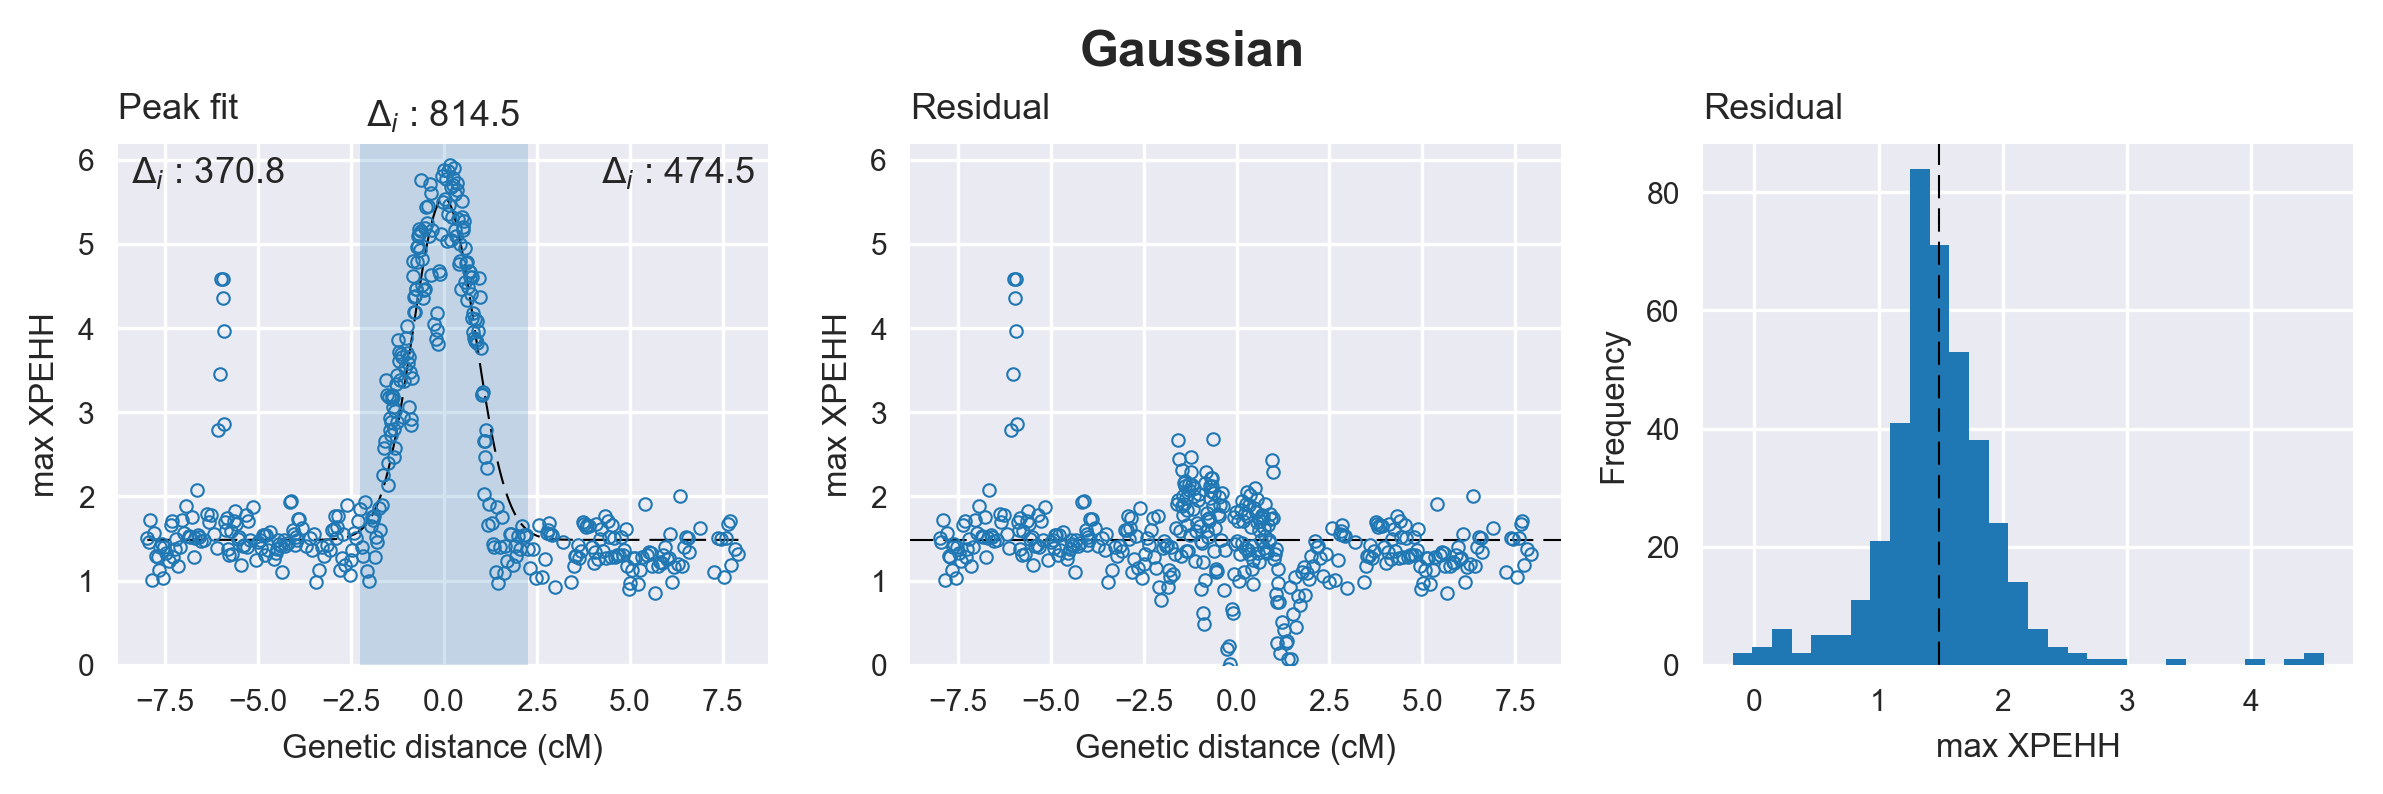

[[Model]]
    (Model(gaussian) + Model(constant))
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 398
    # variables        = 3
    chi-square         = 112.138
    reduced chi-square = 0.284
    Akaike info crit   = -498.157
    Bayesian info crit = -486.197
[[Variables]]
    center:      0 (fixed)
    amplitude:   8.56276933 +/- 0.223938 (2.62%) (init= 3)
    sigma:       0.84118632 +/- 0.022260 (2.65%) (init= 0.2)
    c:           1.48388507 +/- 0.035994 (2.43%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.682 
    C(amplitude, c)              = -0.666 
    C(sigma, c)                  = -0.396 



In [32]:
inspect_peak_fits(center=170.8, flank=8)

## Find peaks

In [58]:
df.head()

seqid  start     end     value
0    2R      1   31433  1.668300
1    2R  31434   49729  2.674605
2    2R  49730   73462  1.483737
3    2R  73463   93497  2.058329
4    2R  93498  111305  2.049382

In [59]:
df.loc[df.seqid == 'X'].head()

seqid   start     end     value
0     X       1  327944  1.182266
1     X  327945  365183  1.240183
2     X  365184  400741  1.131791
3     X  400742  431432  0.768058
4     X  431433  450016  0.691442

In [68]:
starts, ends, values, percentiles = peakfit.extract_windowed_values(df, seqid='X', genome=genome)

In [69]:
starts

array([       1,   327945,   365184, ..., 19650095, 19841715, 23372432], dtype=int32)

In [70]:
ends

array([  327944,   365183,   400741, ..., 19841714, 23372431, 24393108])

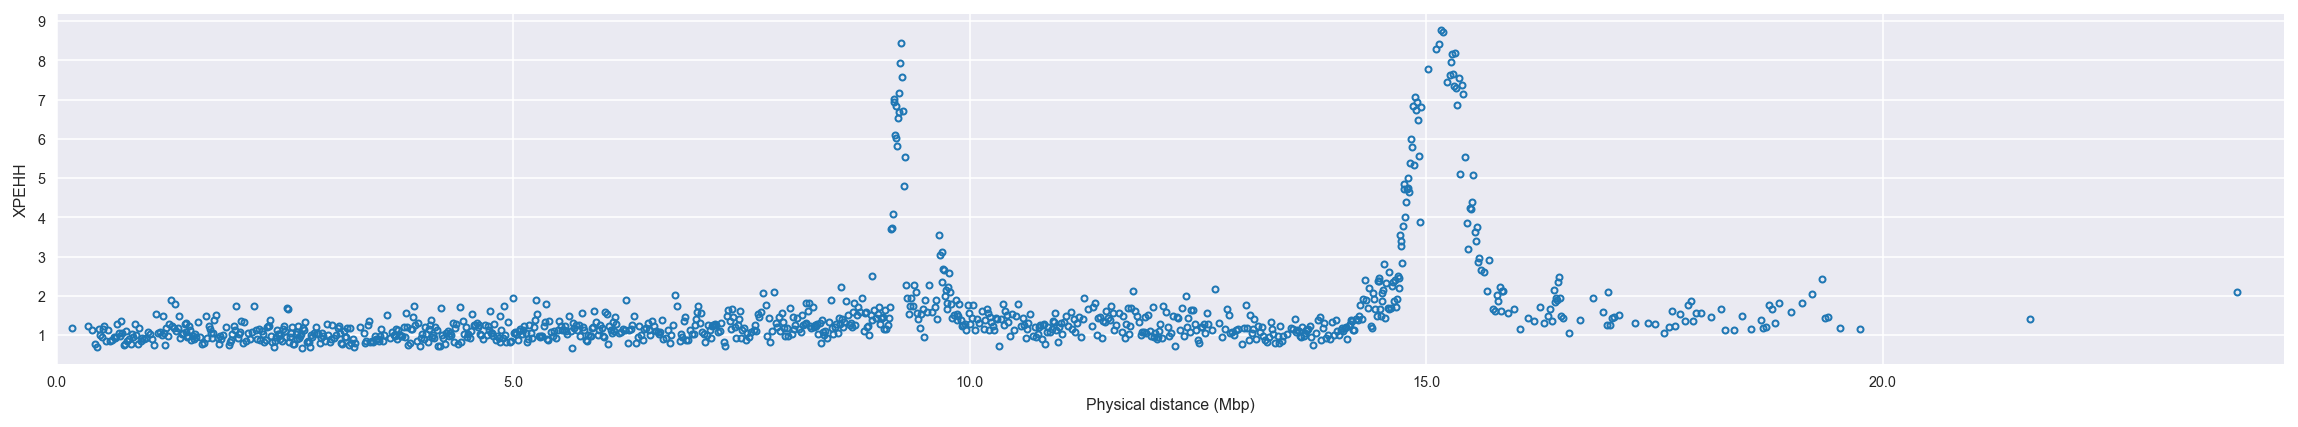

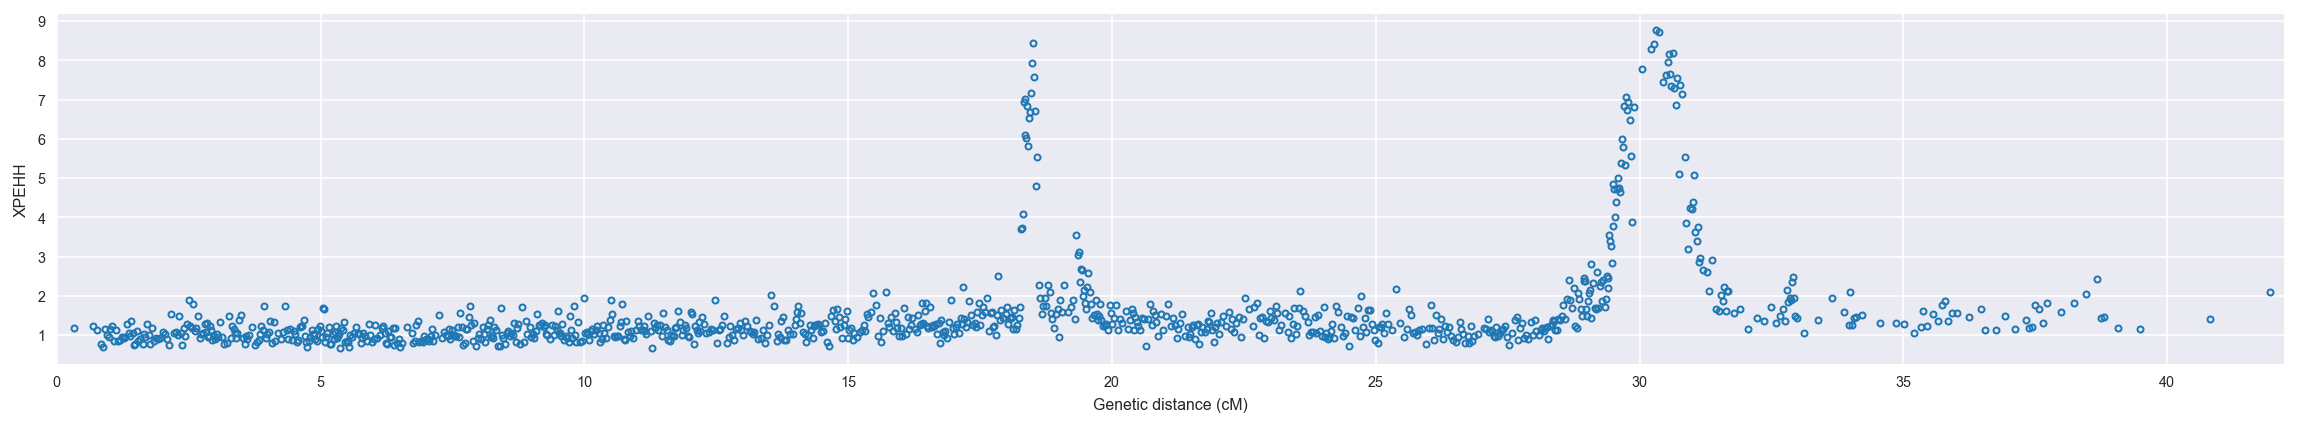

In [71]:
peakfit.plot_windowed_values(starts, ends, values, ylabel='XPEHH');

peakfit.plot_windowed_values(starts, ends, values, ylabel='XPEHH', gmap=gmap['X']);

In [72]:
centers = np.arange(1, ends[-1], 20000)

scan progress 0 2e-06
scan progress 100 4.00000199985
scan progress 200 8.00000200041
scan progress 300 12.000002001
scan progress 400 16.0000020015
scan progress 500 20.0000019985
scan progress 600 24.0000019955
scan progress 700 28.0000019925
scan progress 800 32.0000019896
scan progress 900 36.0000019937
scan progress 1000 40.0000019978
scan progress 1100 41.0146449953
scan progress 1200 42.0146449928
first peak: 461 884.377
Iteration 1
Peak center (index, location): 461, 9220001.0
Delta AIC: 884.4
Flank delta AICs: 549.4, 410.1
find limits of peak
peak limits: 8205764 10241291
check flank fits
FLANK OK: PROCESSING PEAK
setup output directory for this peak
plot some diagnostics about the peak finding algorithm
plot some diagnostics for the peak fit
find focus of selection
epicenter: 9220001
found focus: 9200001 9240001
yield peak
subtract peak from values
rescan region around the peak
scan progress 100 4.00000199985
scan progress 200 8.00000200041
scan progress 300 12.000002001
scan

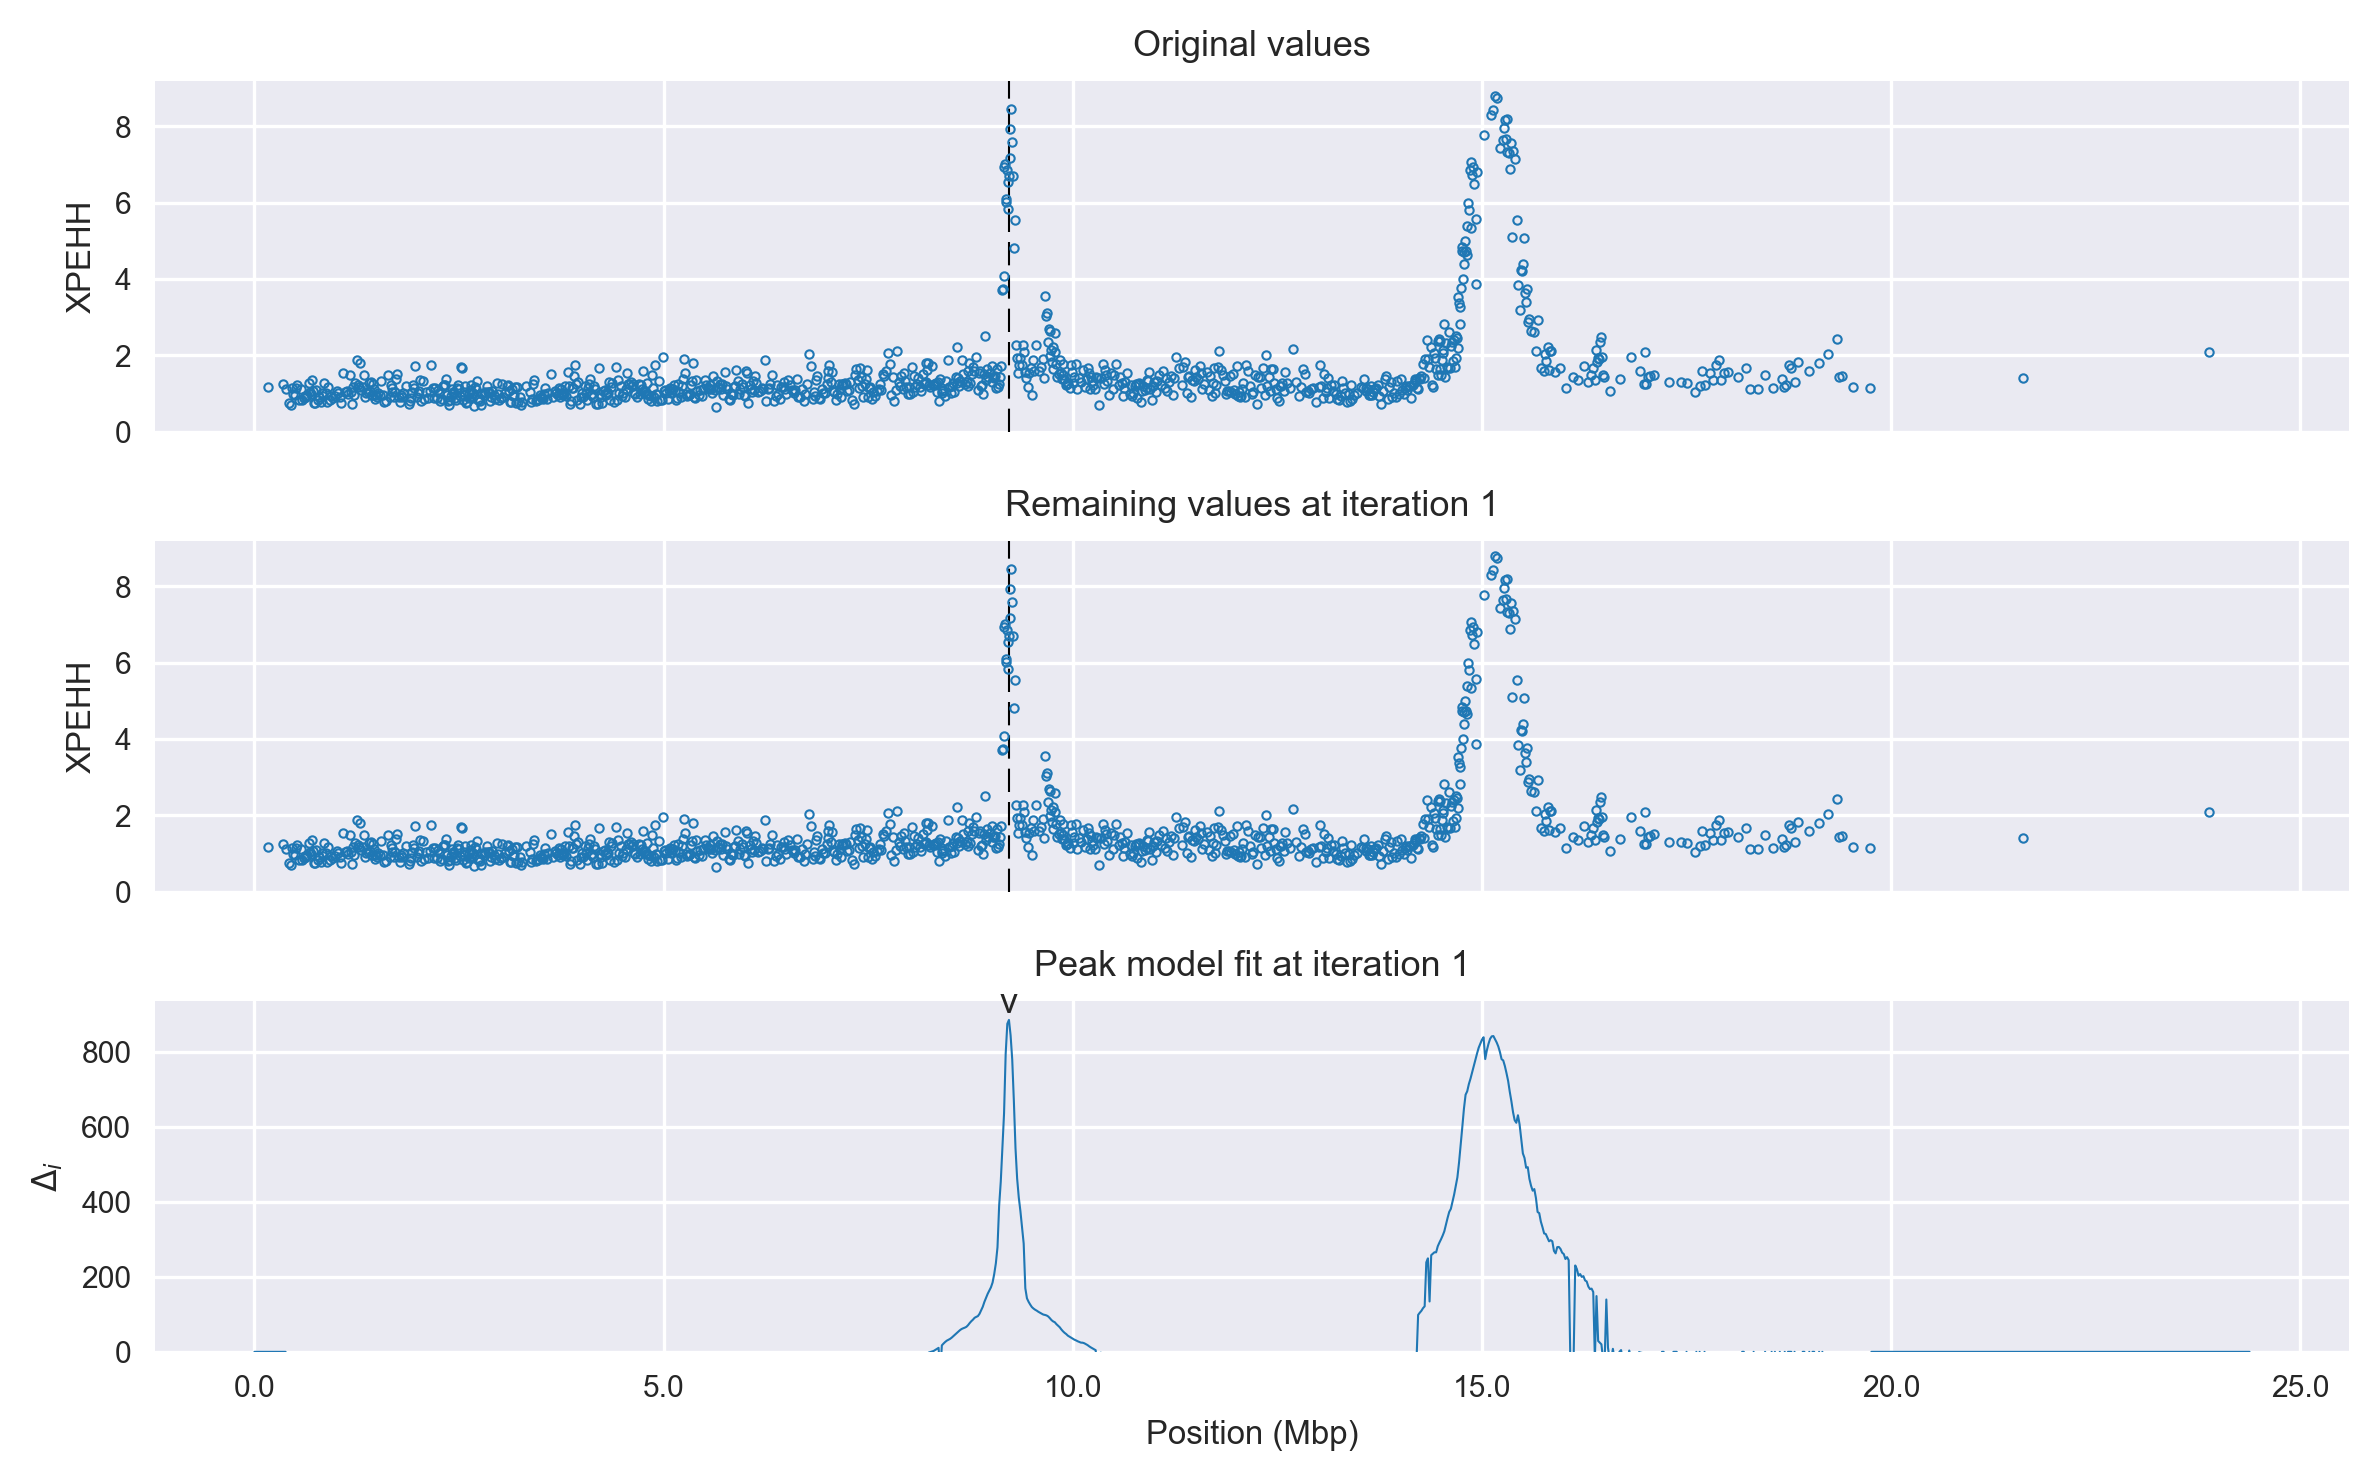

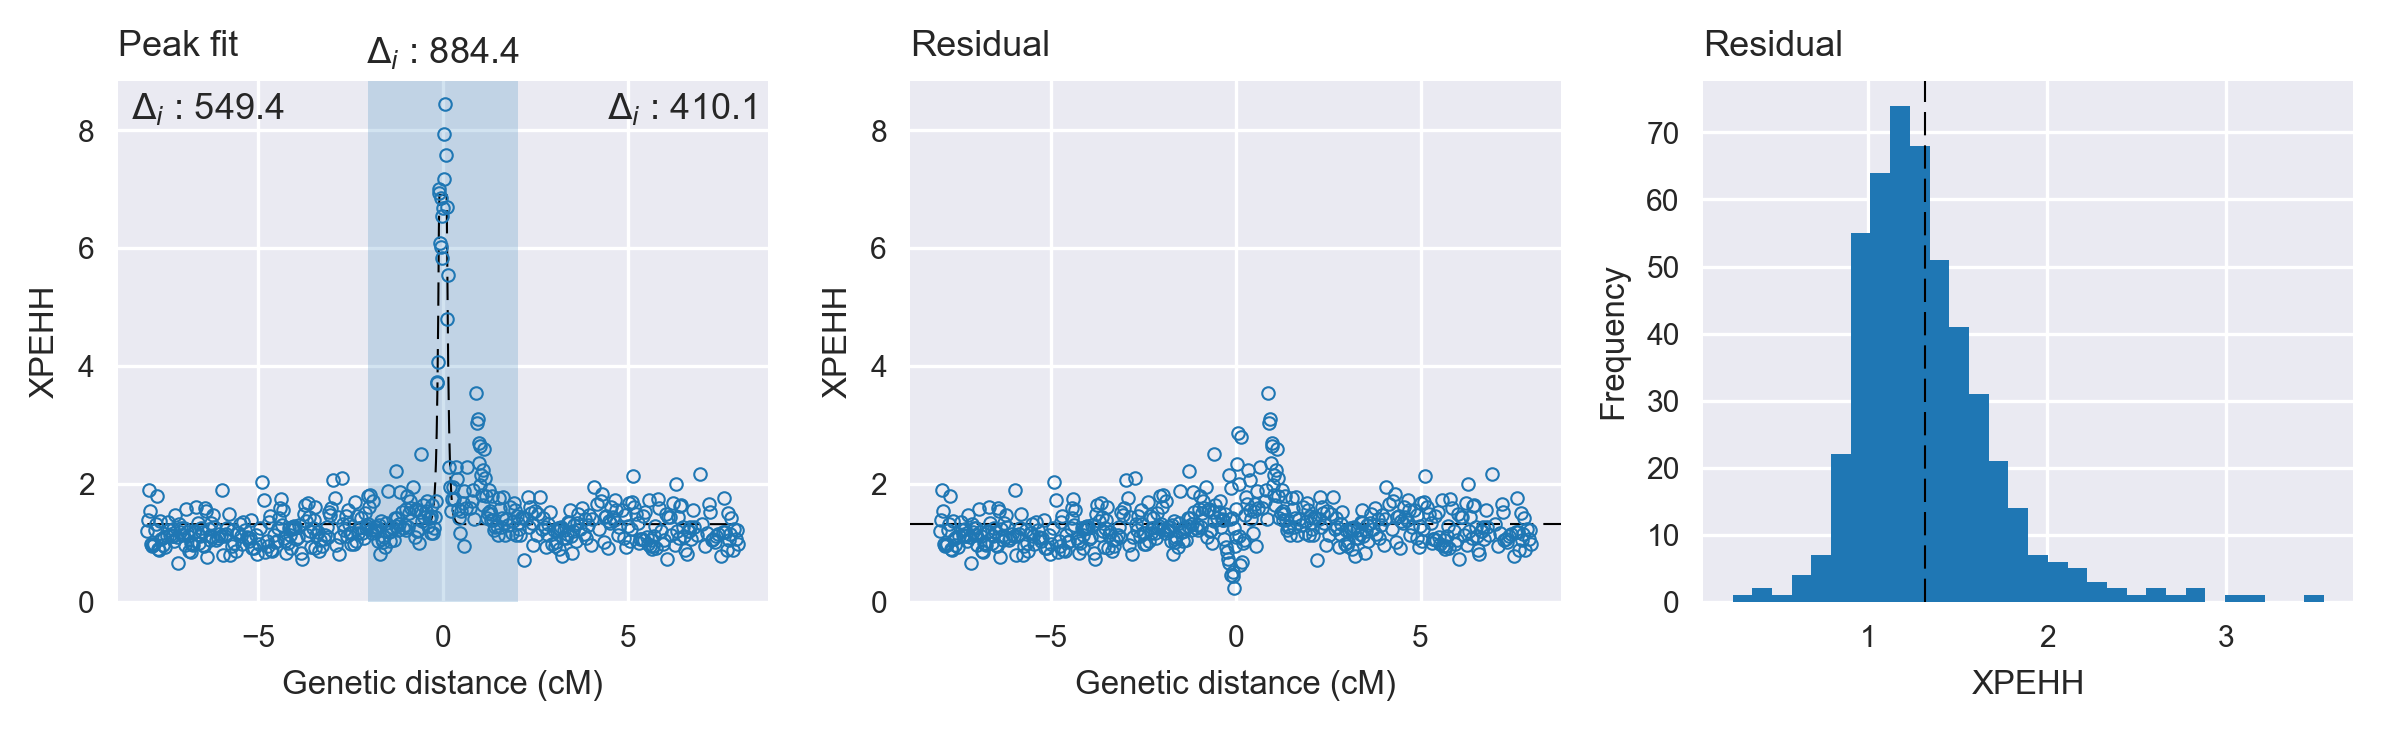

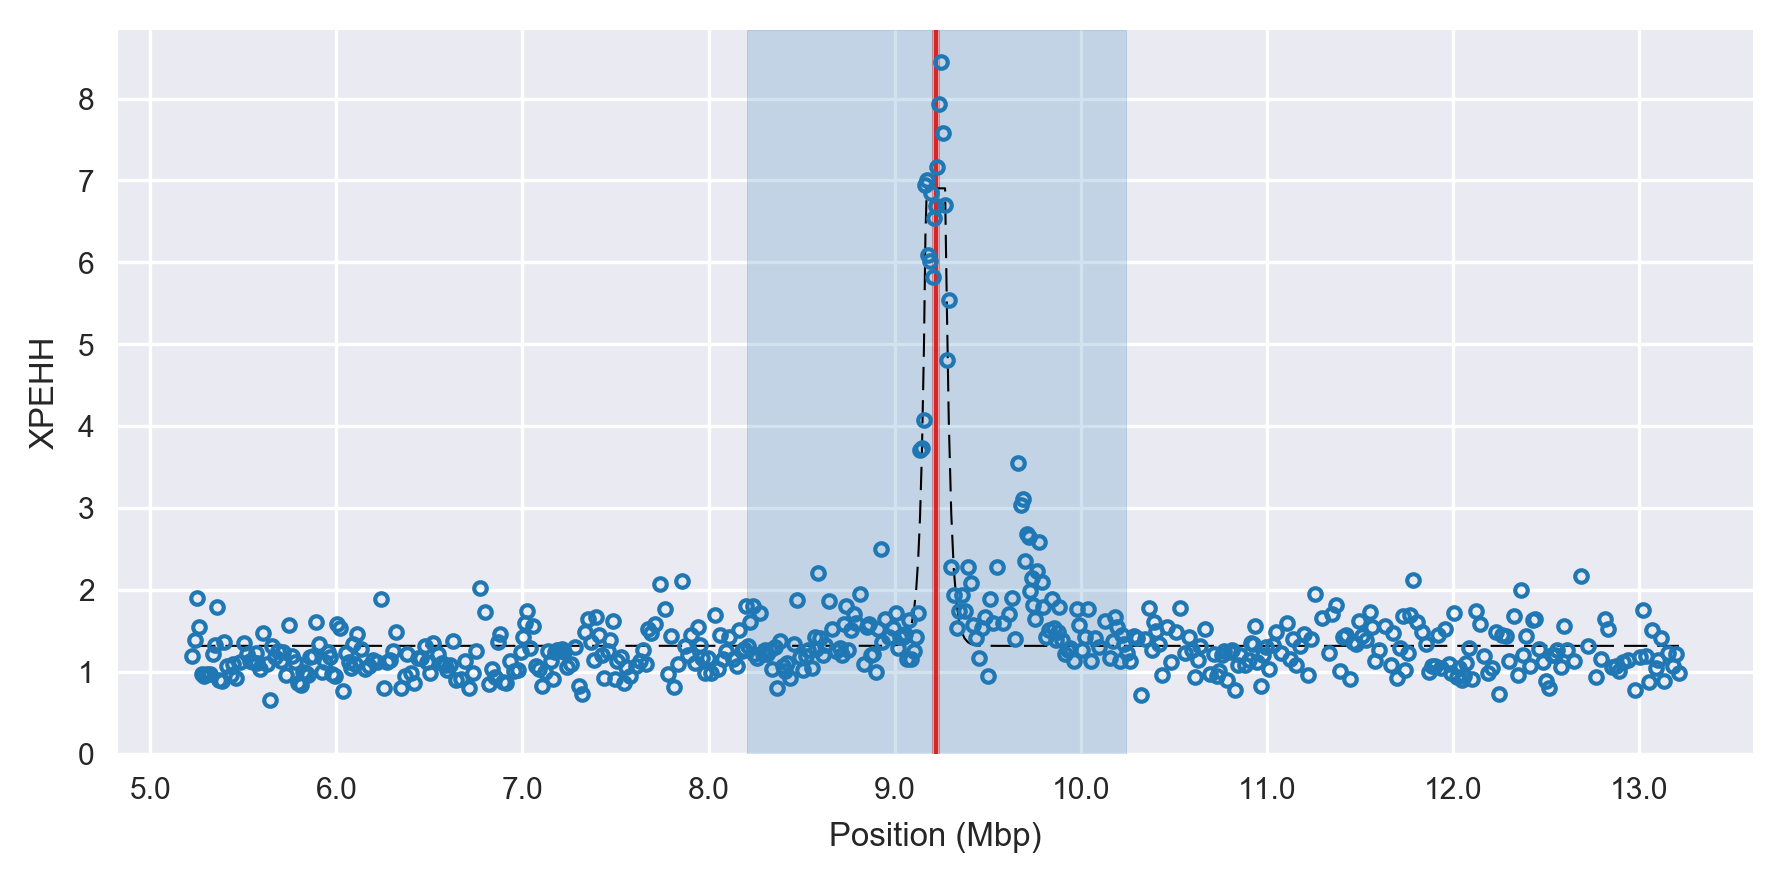

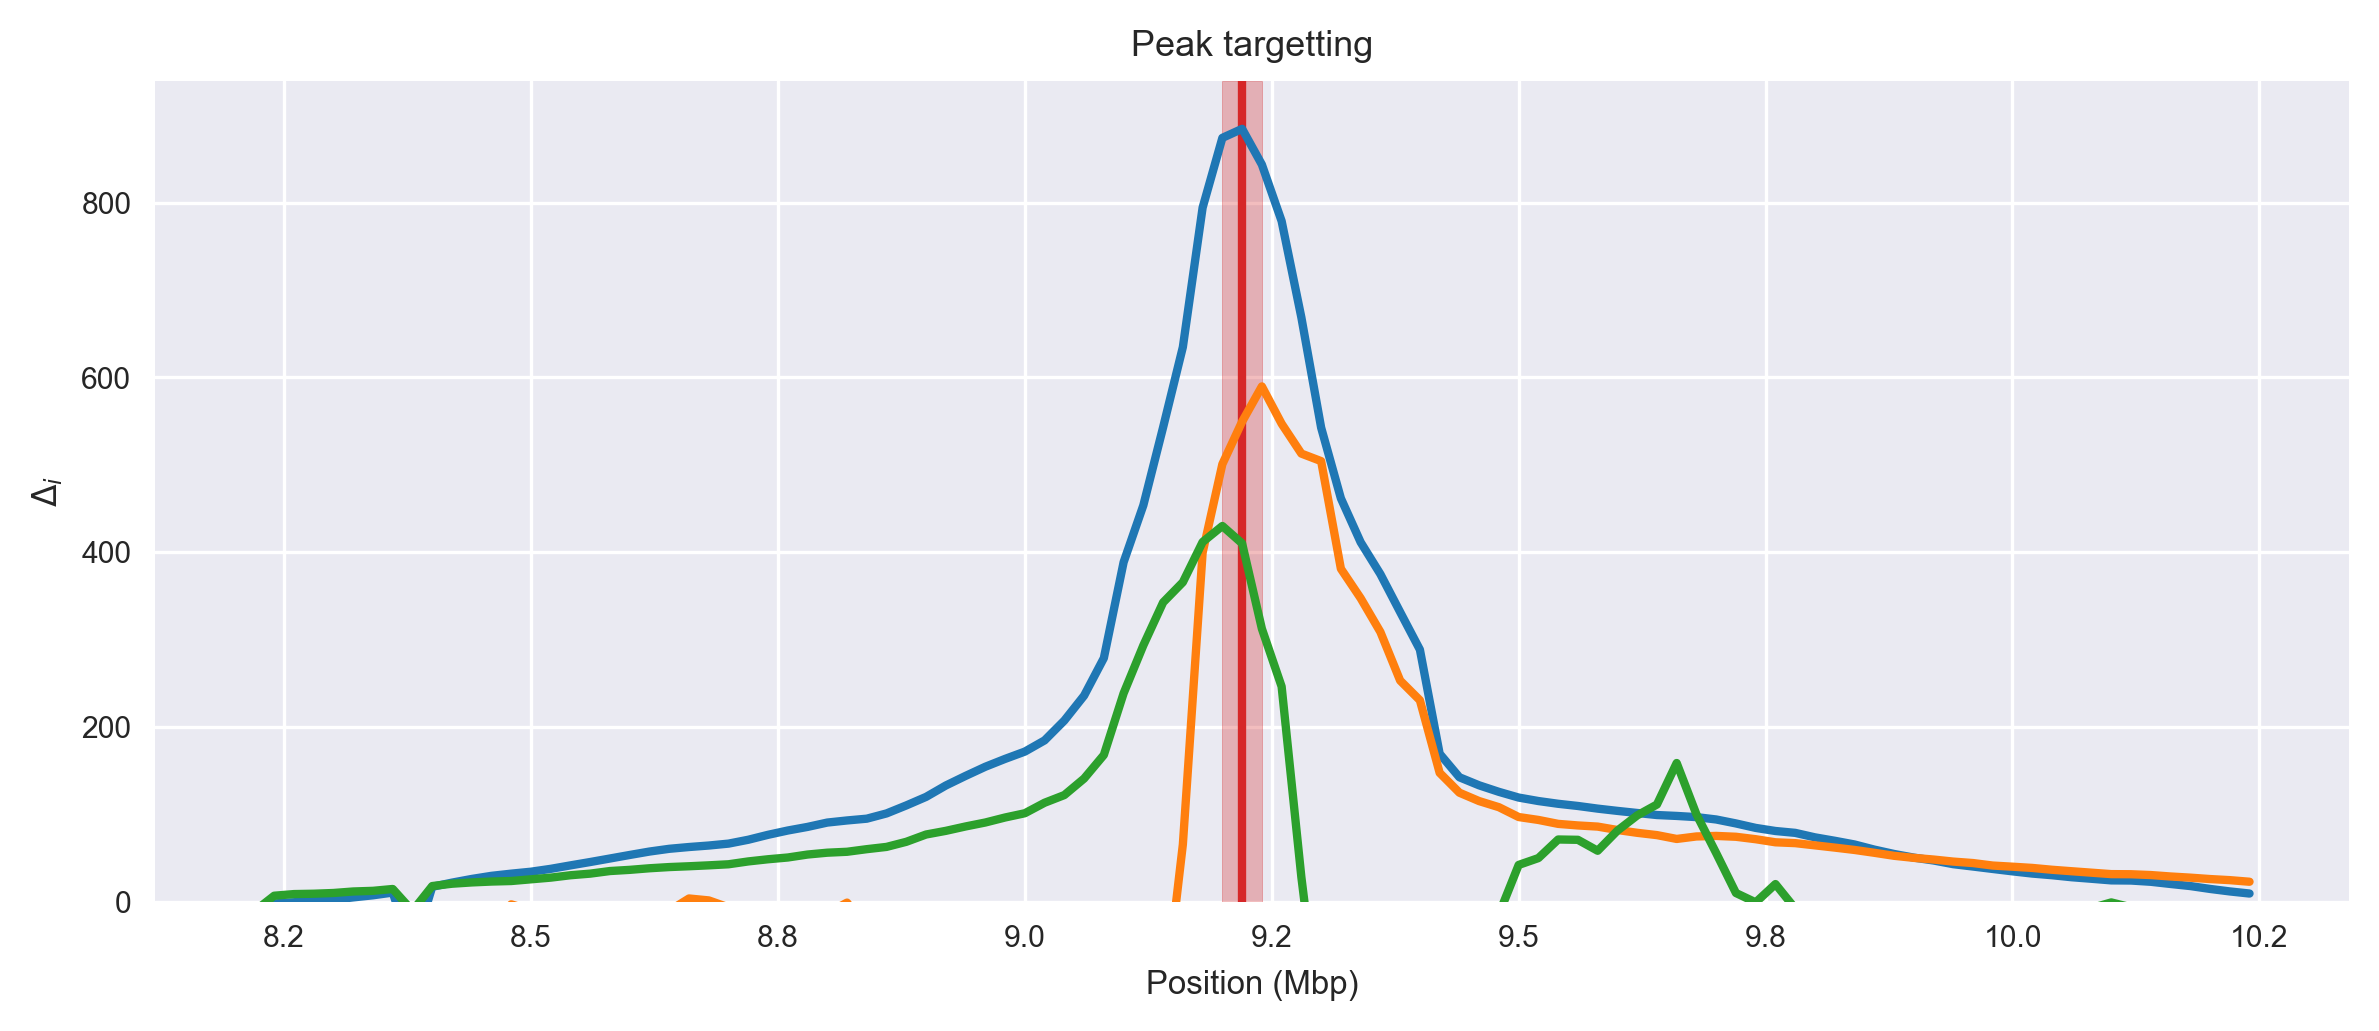

find the next peak
next peak: 757 841.337
Iteration 2
Peak center (index, location): 757, 15140001.0
Delta AIC: 841.3
Flank delta AICs: 531.4, 290.6
find limits of peak
peak limits: 14082758 16210559
check flank fits
FLANK OK: PROCESSING PEAK
setup output directory for this peak
plot some diagnostics about the peak finding algorithm
plot some diagnostics for the peak fit
find focus of selection
epicenter: 15140001
extend signal left 15100001
extend signal left 15080001
extend signal left 15060001
extend signal right 15180001
extend signal right 15200001
found focus: 15060001 15200001
yield peak
subtract peak from values
rescan region around the peak
scan progress 400 16.0000020015
scan progress 500 20.0000019985
scan progress 600 24.0000019955
scan progress 700 28.0000019925
scan progress 900 36.0000019937
scan progress 1000 40.0000019978
scan progress 1100 41.0146449953
scan progress 1200 42.0146449928


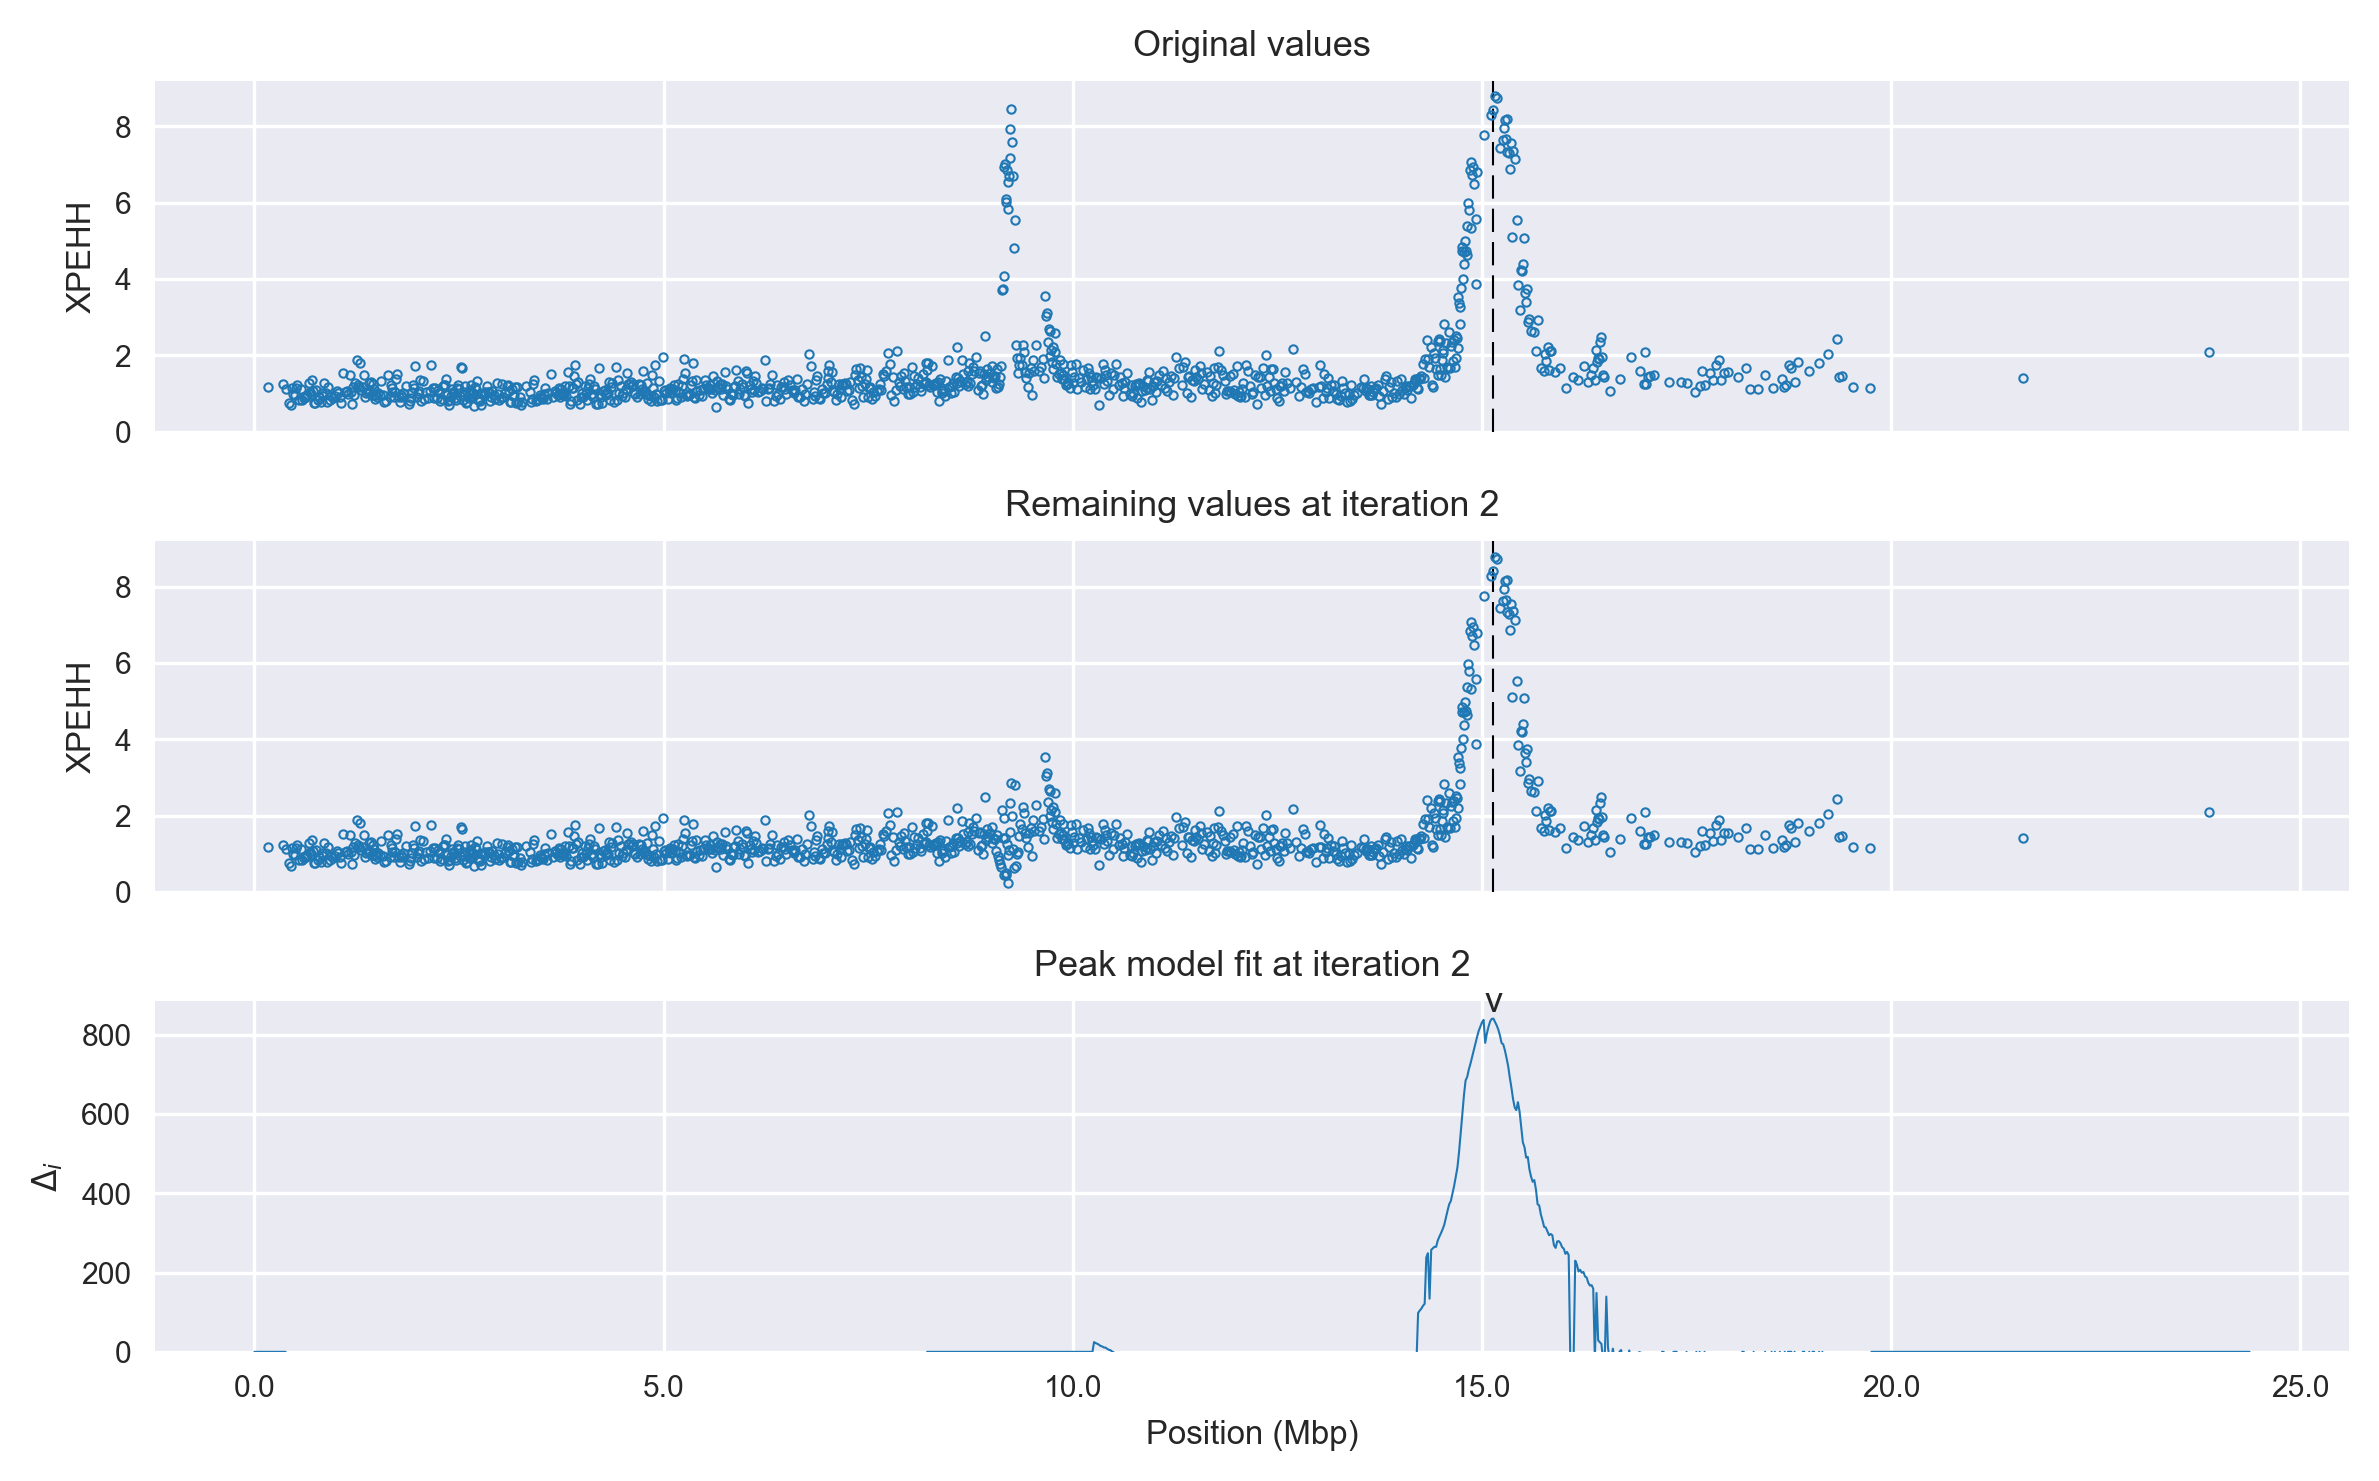

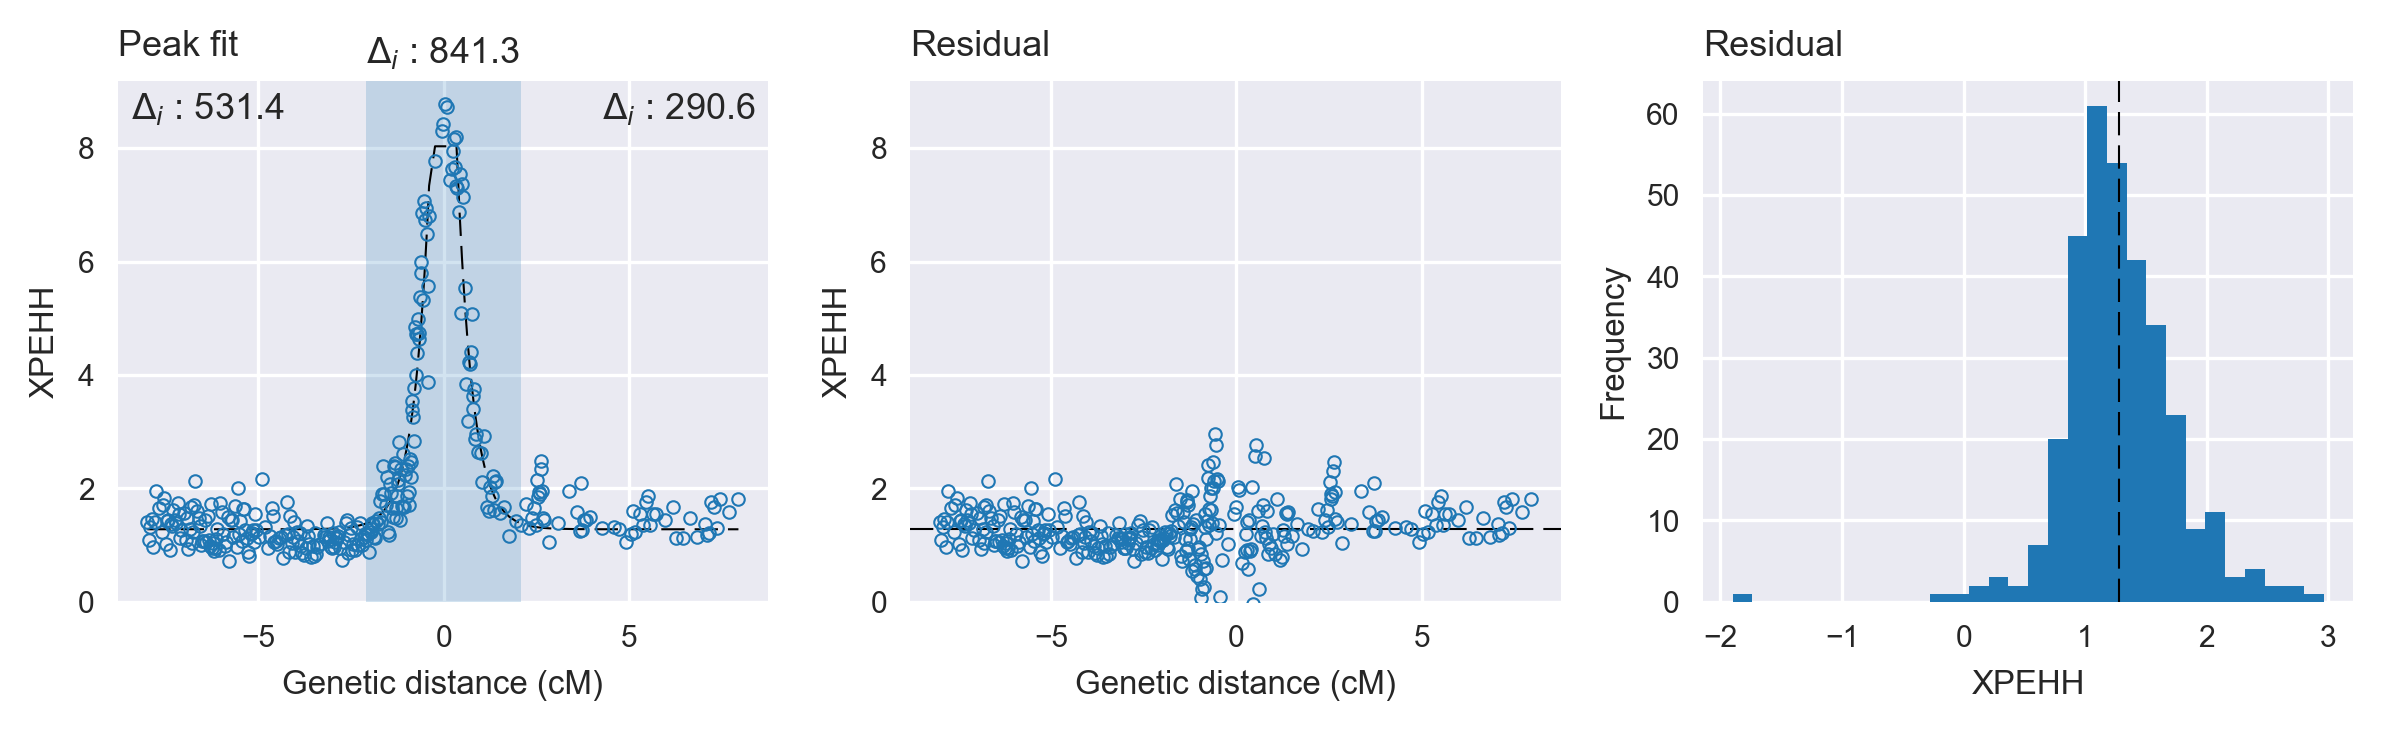

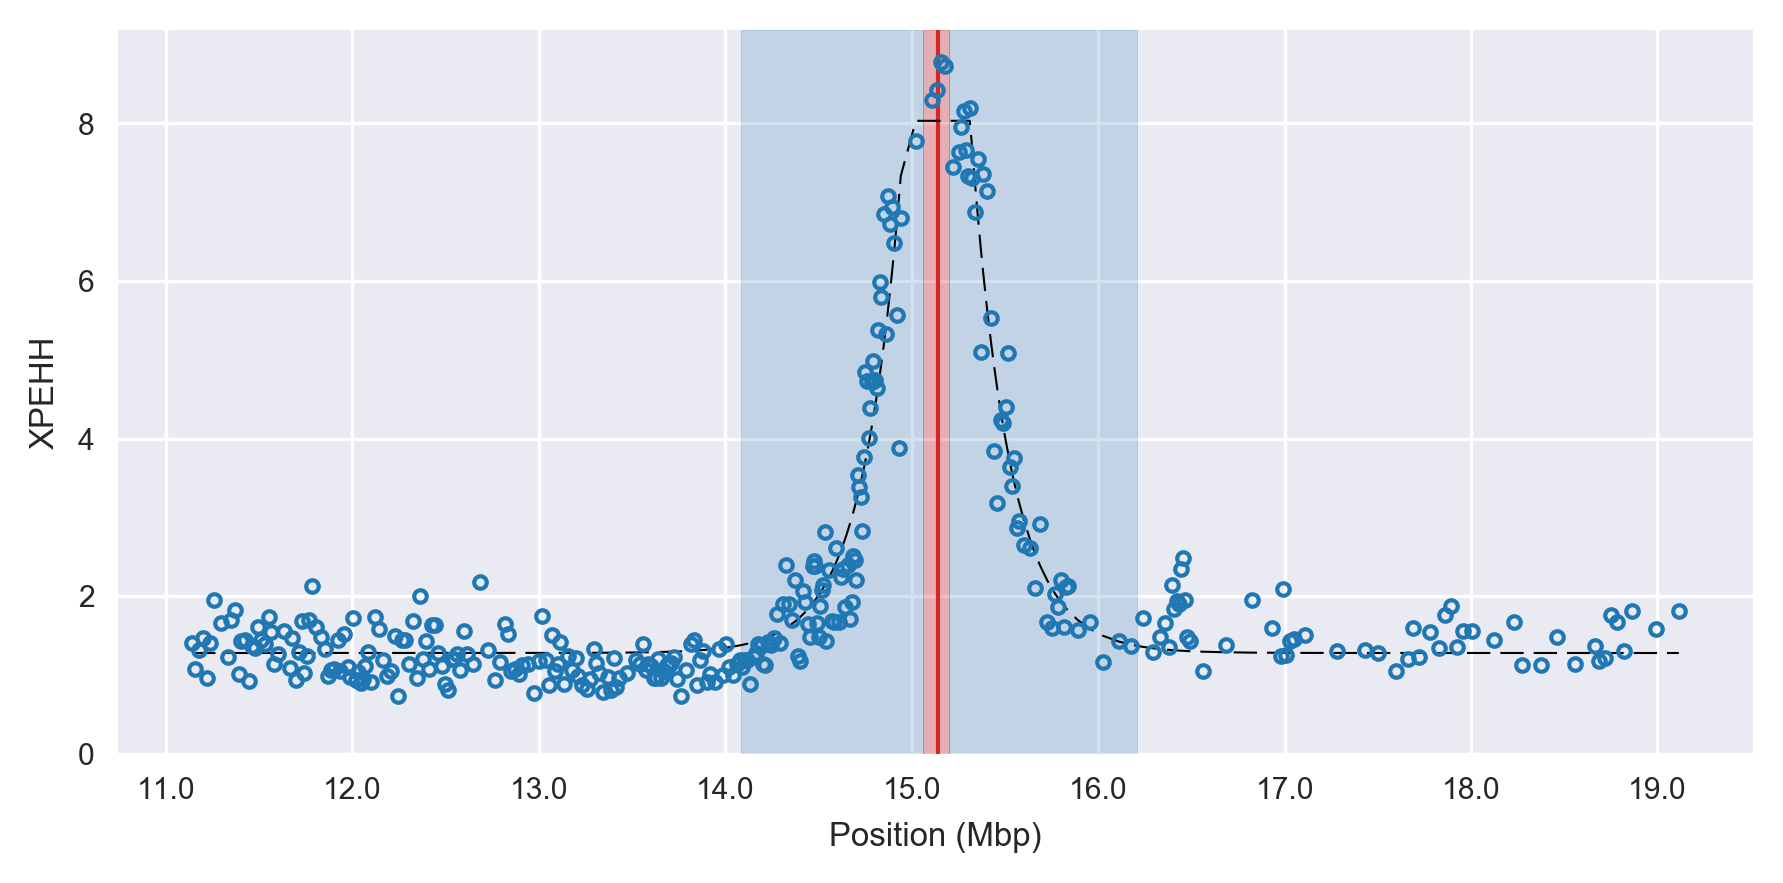

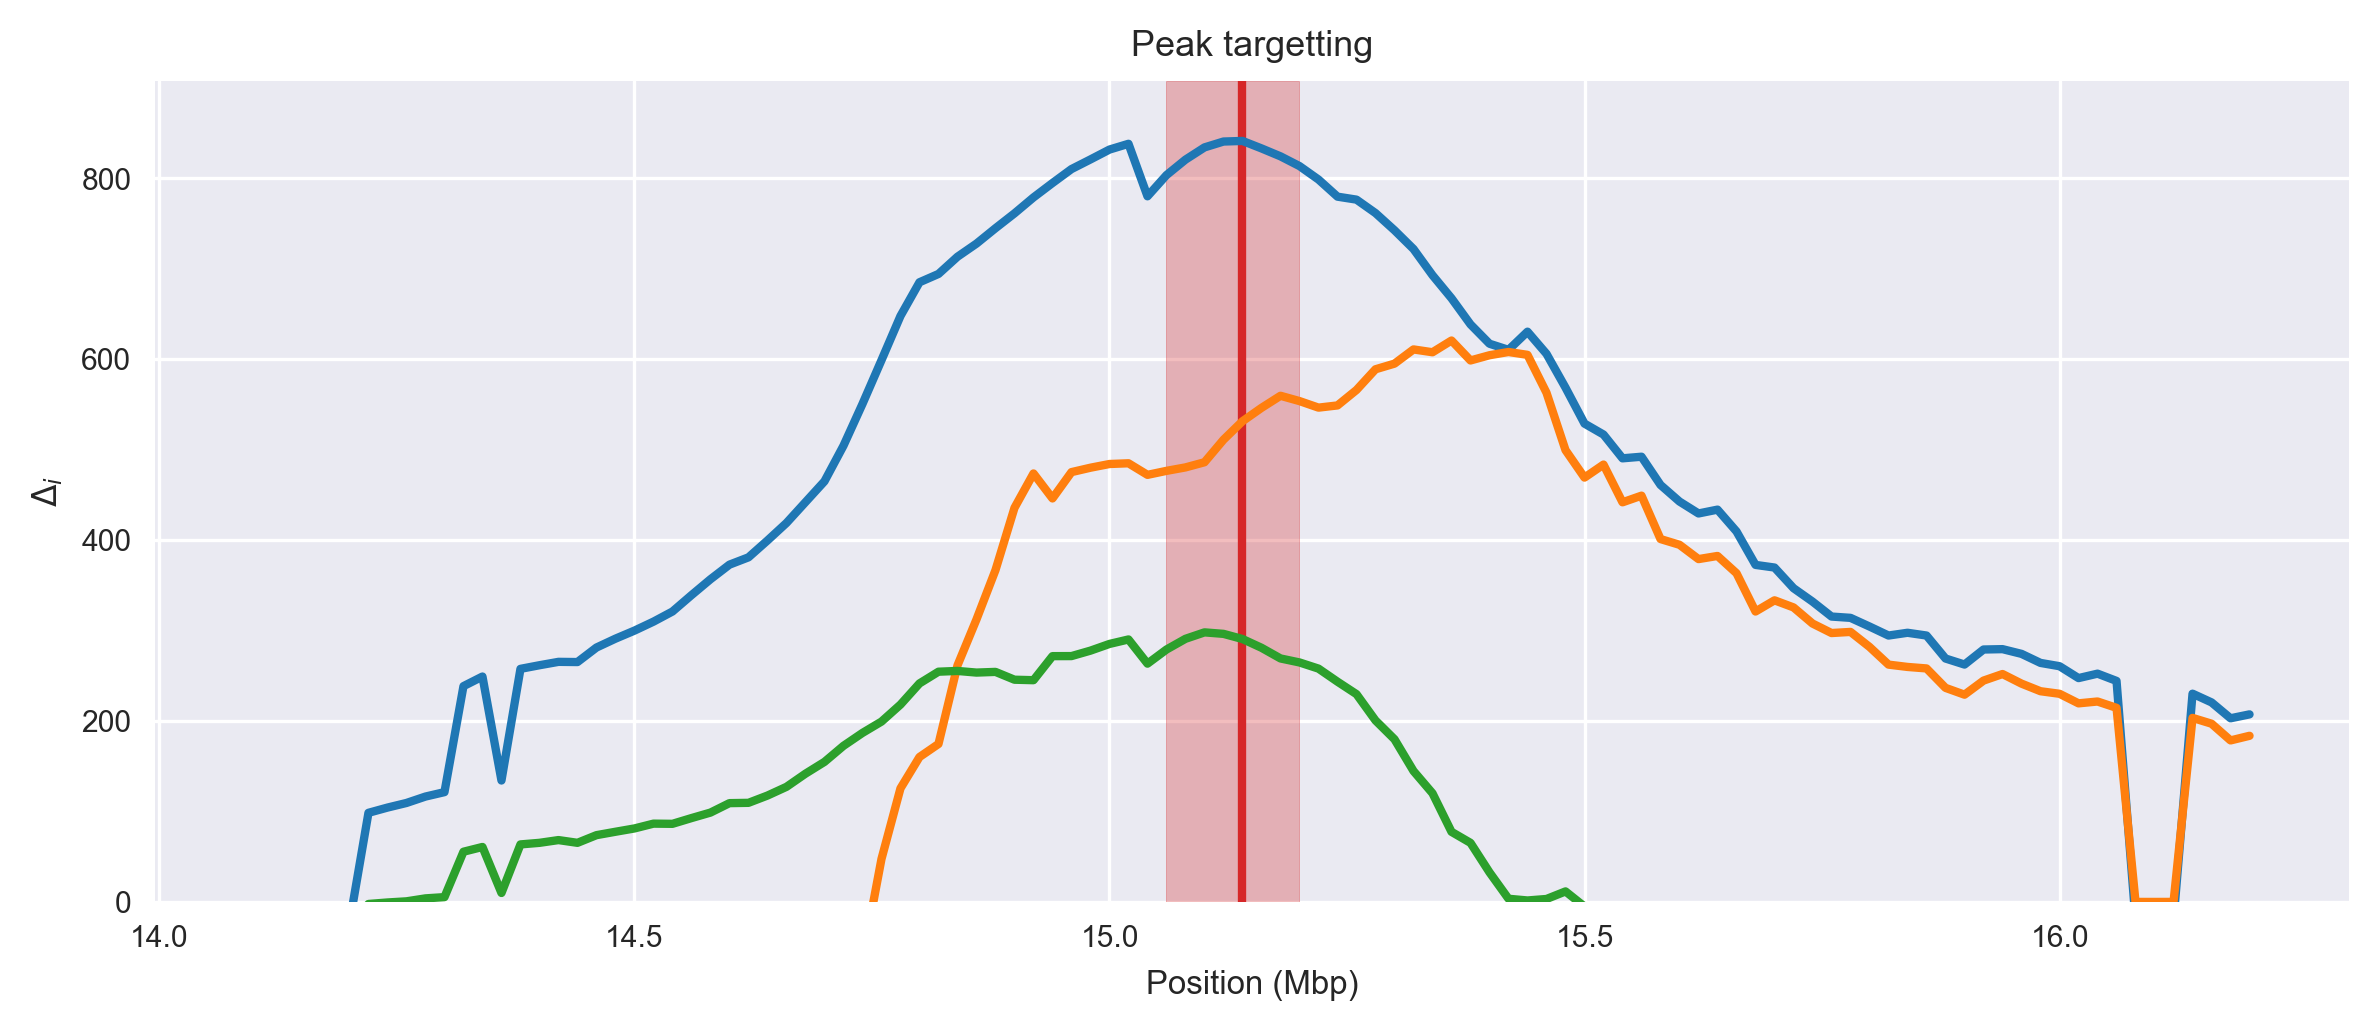

find the next peak
next peak: 484 119.301
Iteration 3
Peak center (index, location): 484, 9680001.0
Delta AIC: 119.3
Flank delta AICs: 54.1, 124.2
find limits of peak
peak limits: 5678601 13680061
check flank fits
FLANK OK: PROCESSING PEAK
setup output directory for this peak
plot some diagnostics about the peak finding algorithm
plot some diagnostics for the peak fit
find focus of selection
epicenter: 9680001
found focus: 9660001 9700001
yield peak
subtract peak from values
rescan region around the peak
scan progress 100 4.00000199985
scan progress 200 8.00000200041
scan progress 700 28.0000019925
scan progress 800 32.0000019896


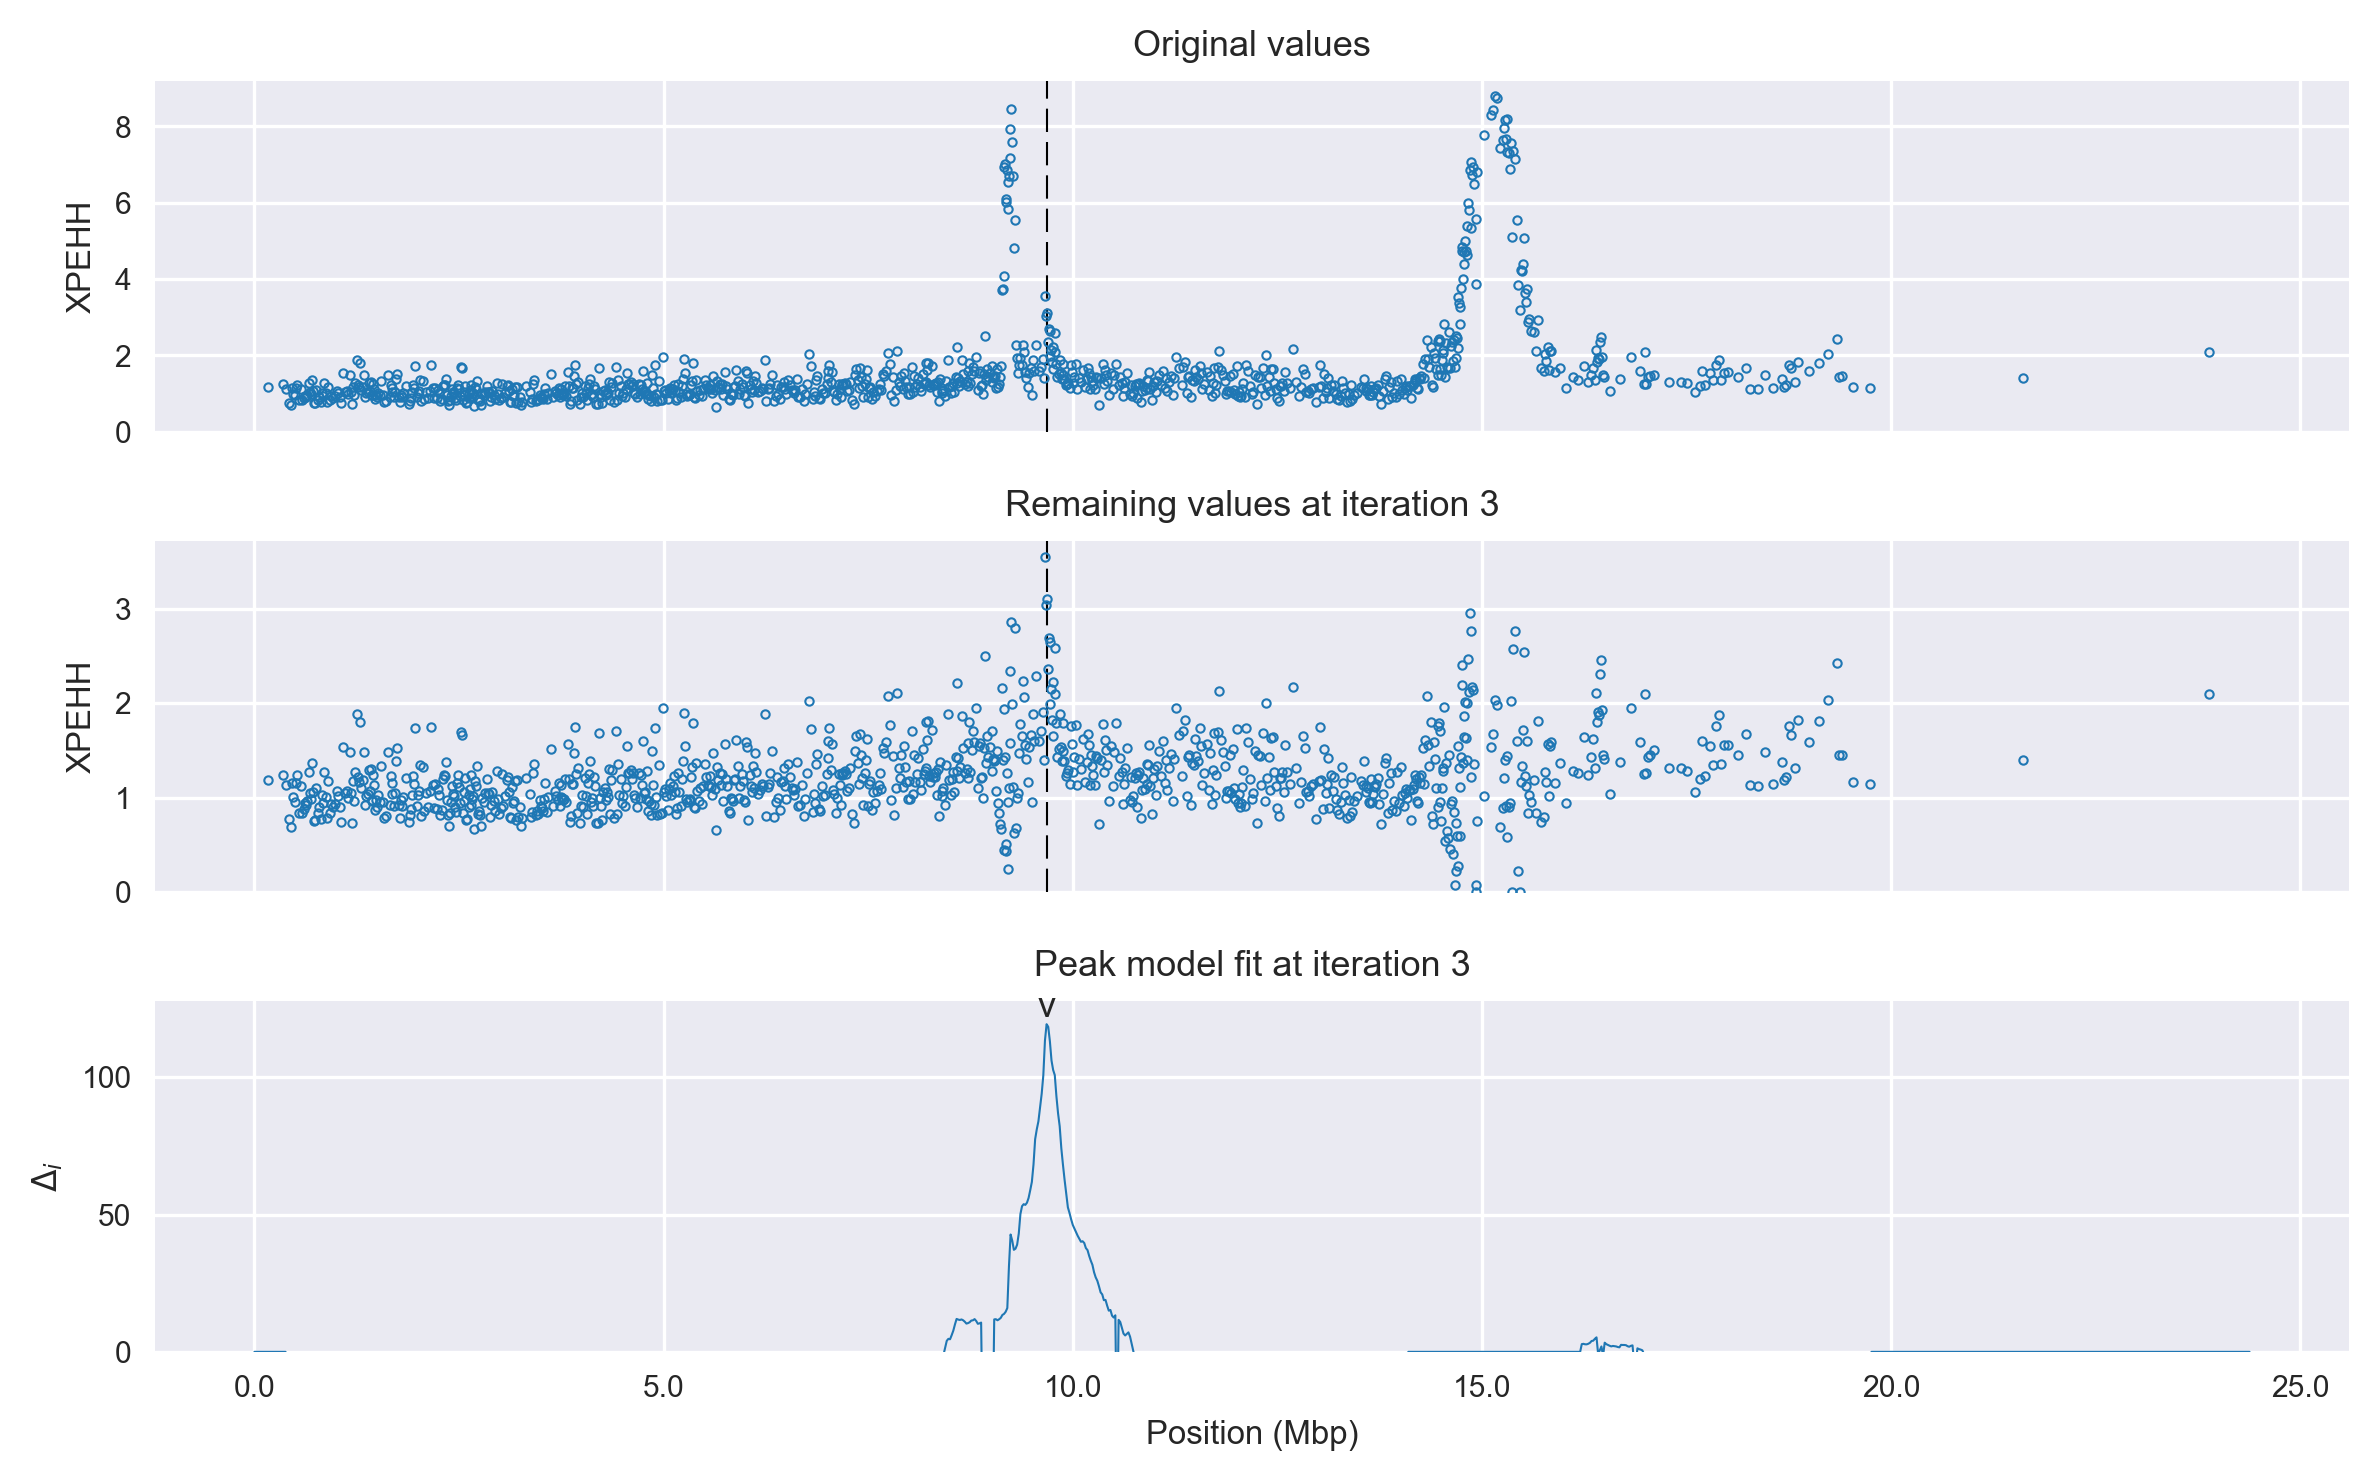

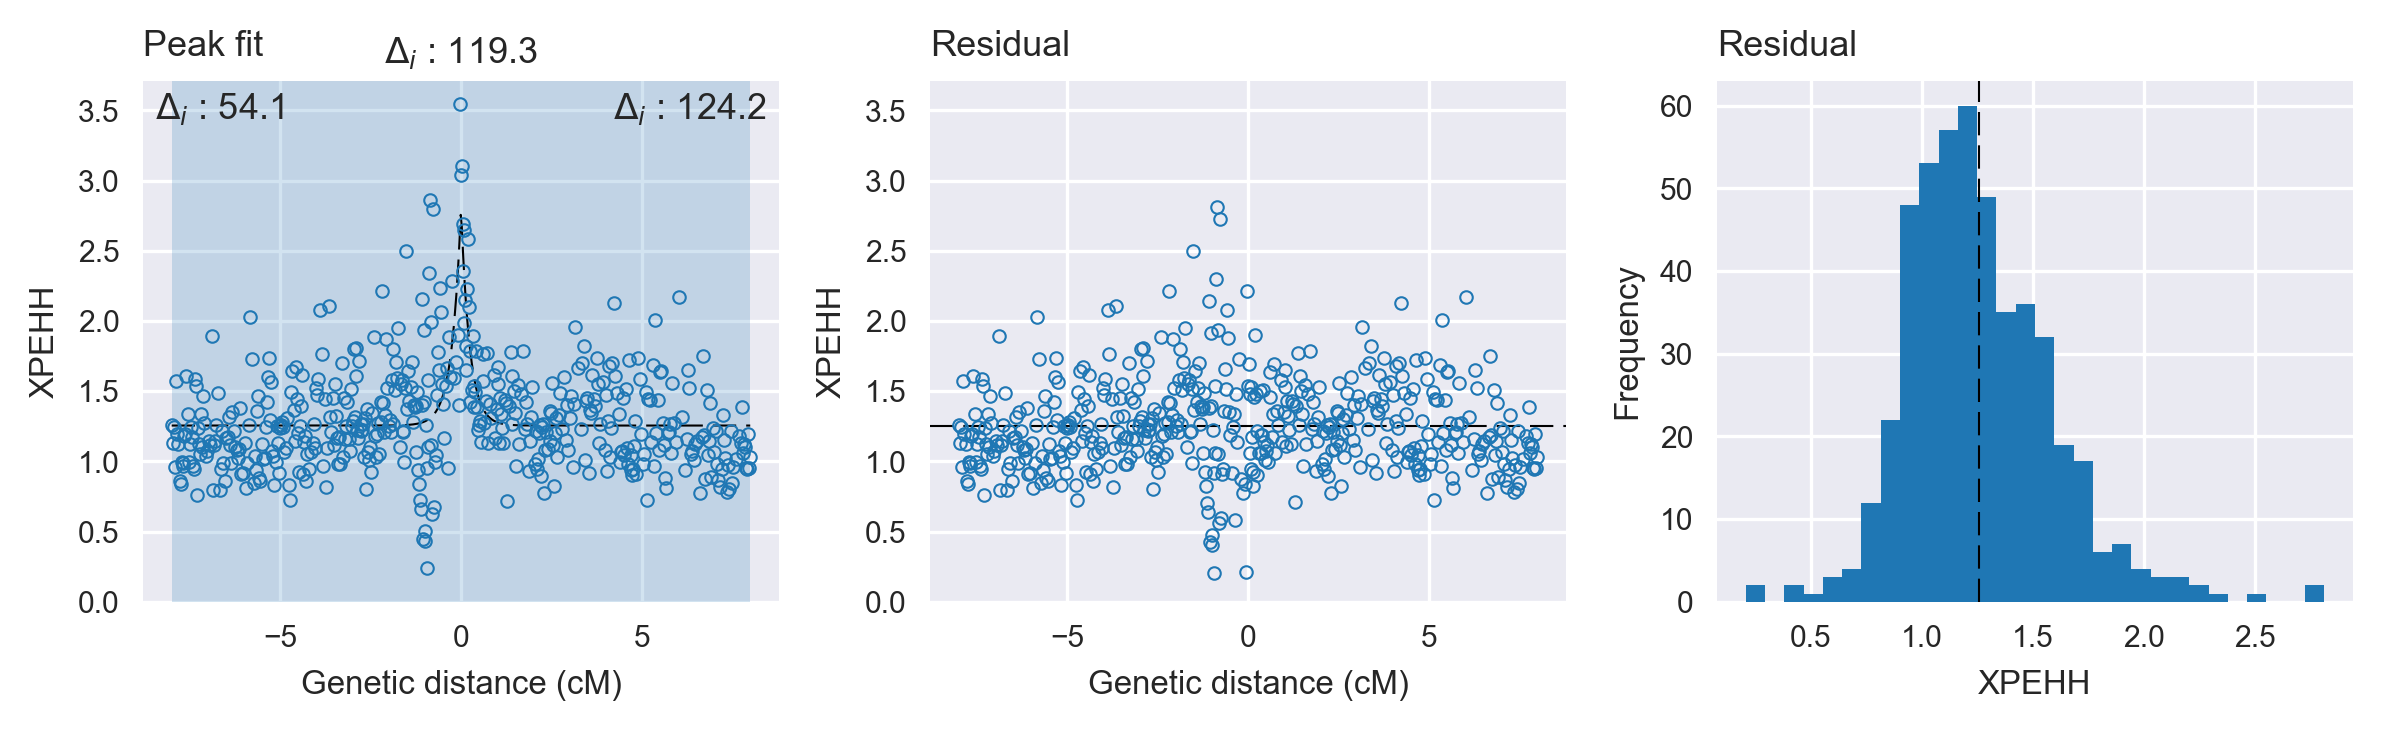

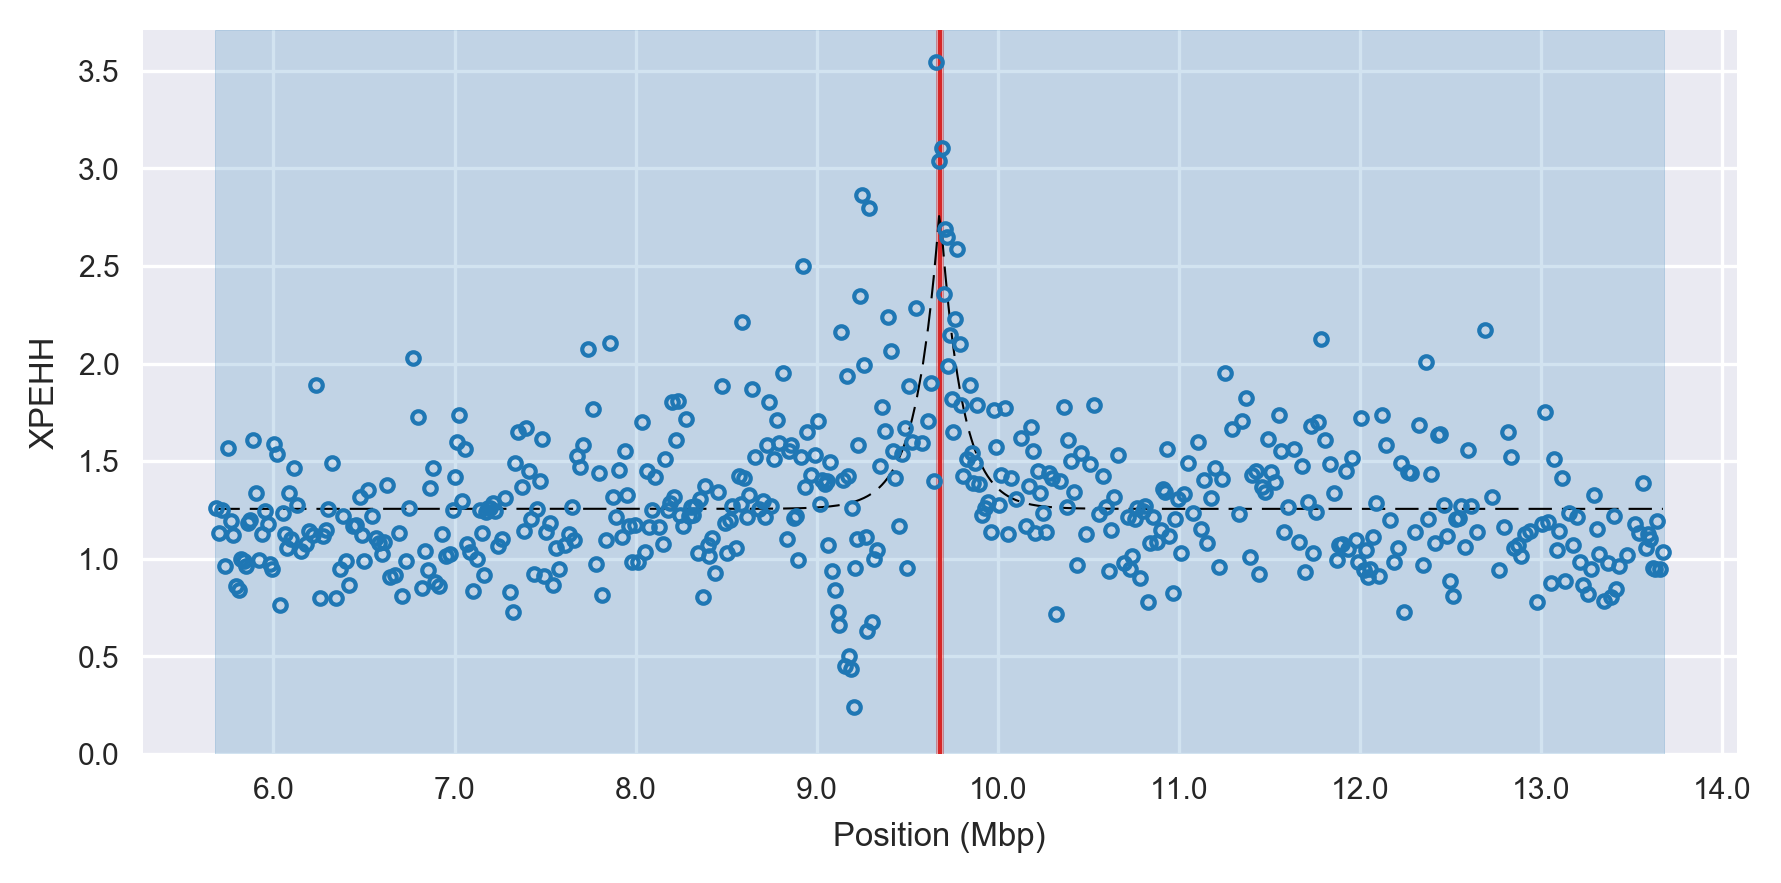

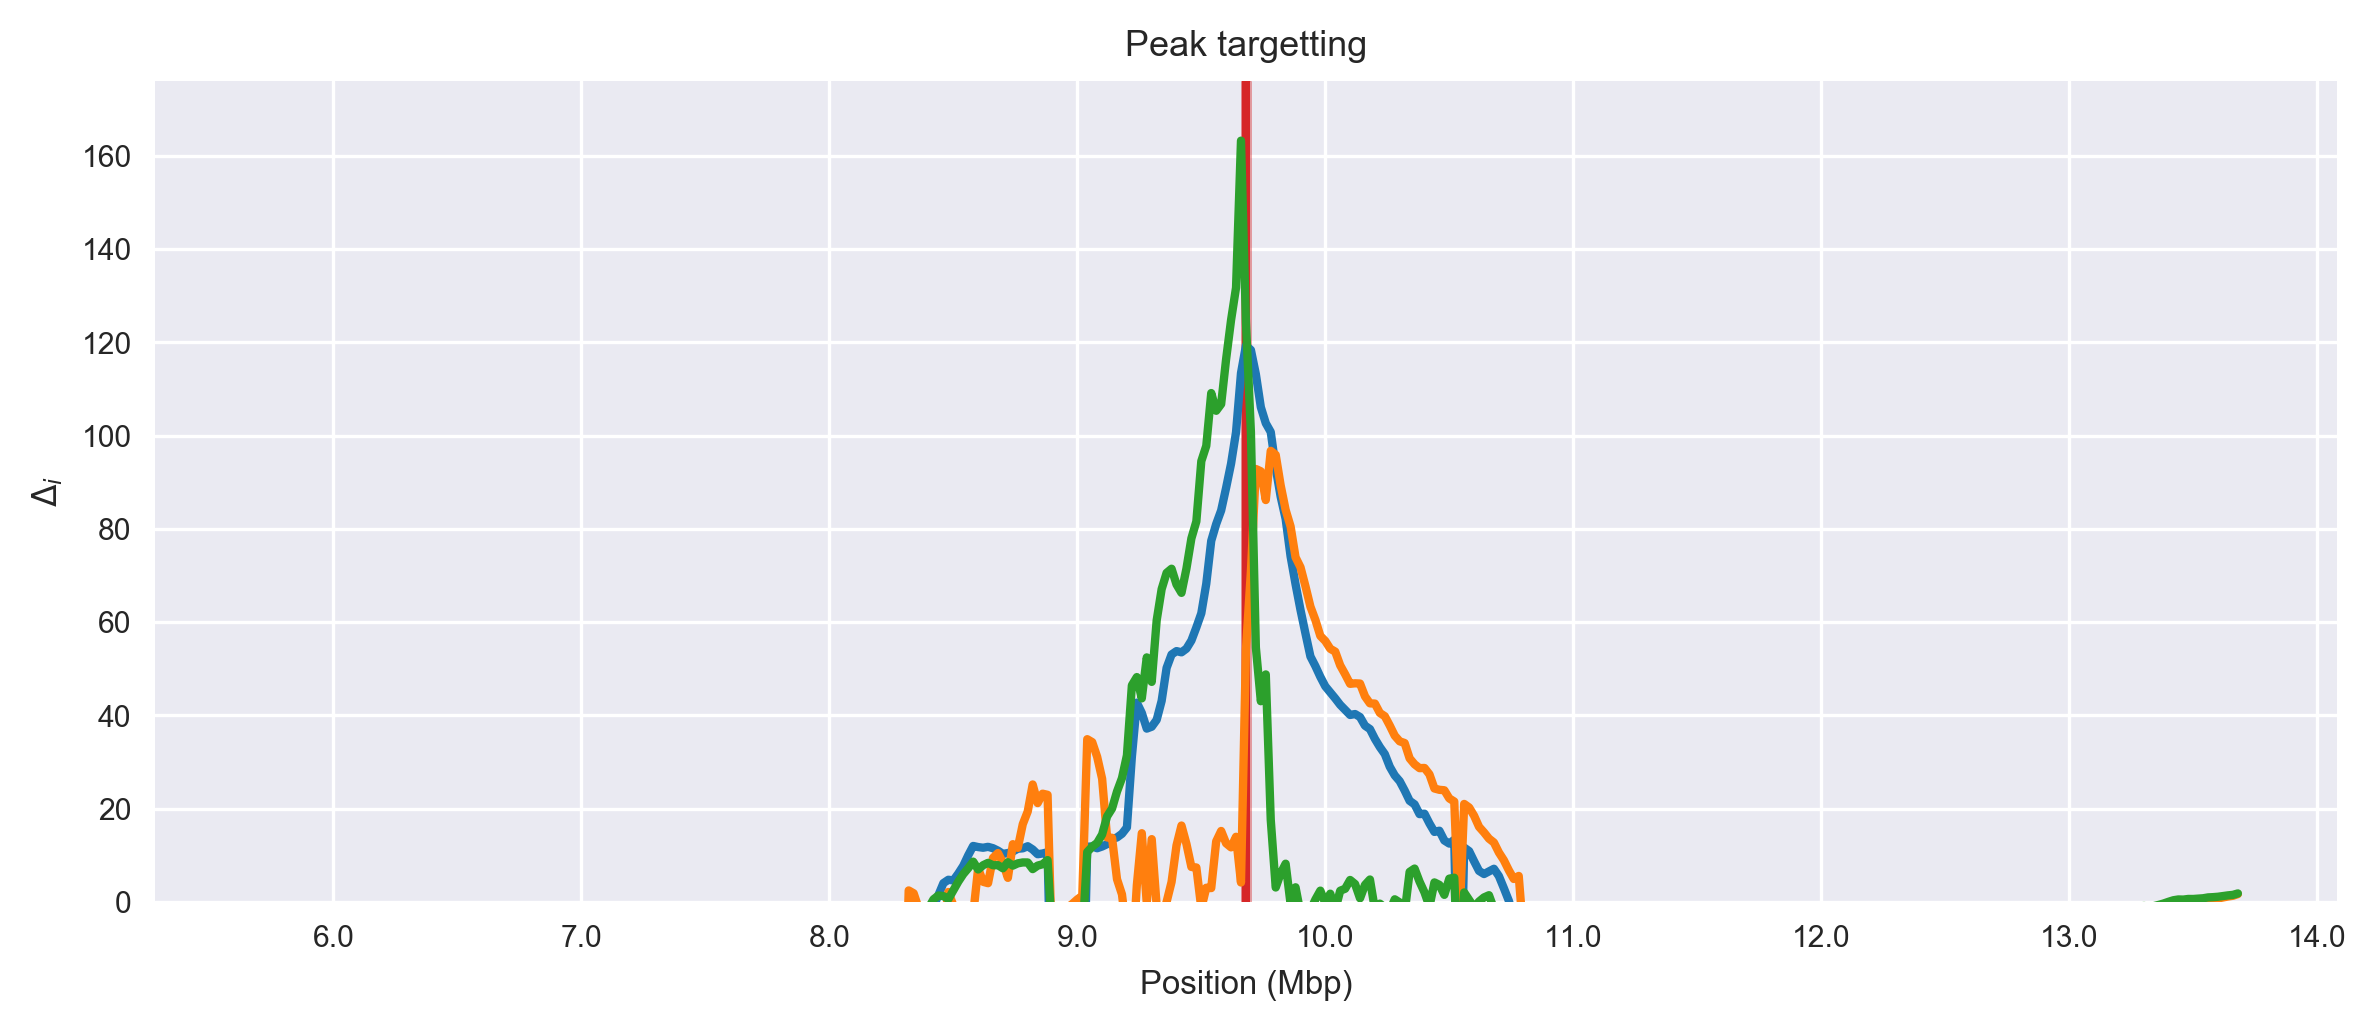

find the next peak
next peak: 742 17.7423
all done


In [73]:
peaks = peakfit.find_peaks(starts=starts, ends=ends, values=values, percentiles=percentiles, centers=centers, 
                           gflank=8, gmap=gmap['X'], fitter=asymexp_fitter, show_plots=True, statistic_label='XPEHH', 
                           log_file=None, dpi=150)
peaks = list(peaks)